In [1]:
load('./suppl_data/classification_results.rda')

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file './suppl_data/classification_results.rda', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [1]:
# source('vahid_lib.R')
library(Biobase)
library(biomaRt)
library(limma)
library(edgeR)
library(preprocessCore)
library(GEOquery)
library(sparcl)
library(gplots)
library(splines)
library(knitr)
library(ggplot2)
library(reshape2)
library(png)
library(MASS)
library(coin)
library(RedeR)
library(igraph)
library(metap)
library(topGO)
library(coda)
library(emdbook)
library(GSEABase)
library(org.Hs.eg.db)
library(colorRamps)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To 

# 3 gene enrichment test
### first selecting protein coding gene

In [2]:
# setwd("/Volumes/Work/Vahid_work/classification_newcode/outData/")
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/rASDgenes/rASDgenes.rda")
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/CompiledData/proteinCodingGenes.rda")
load('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/all_usable_data.rda')
# DEgenes$entrezgene=as.character(DEgenes$entrezgene)

gene_all = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/ALL_GENE_FEATURE.txt')$X1
print(paste("Number of expressed protien coding genes in the dataset:",length(allProteinCodingGenes))) #14854
allProteinCodingGenes = allProteinCodingGenes[allProteinCodingGenes %in% as.character(gene_all)]
print(paste("Overlap with feature:", length(allProteinCodingGenes[allProteinCodingGenes %in% as.character(gene_all)])))

[1] "Number of expressed protien coding genes in the dataset: 14832"
[1] "Overlap with feature: 11695"


In [3]:
write.table(allProteinCodingGenes, '/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/ALL_PROTEINGENE_FEATURE.txt',row.names=F)

In [4]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/rASDgenes/rASDgenes.rda")
sfariAtts=sfariAtts[sfariAtts$Entrez_Gene_ID %in% as.character(gene_all),]
allProteinCodingGenes_1 = allProteinCodingGenes
sfariAtts_1 =sfariAtts

### overlap with the network we used in the Vahid nature nueral science paper

In [5]:
.myNetGeneExtractorFn=function(inputNet){
  #This functions retruns the list of genes that are present in the input network
  #inputNet: input network that is expected to have gene names in Fnode and Snode columns
  genelist=unique(c(as.character(inputNet$Fnode),as.character(inputNet$Snode)))
  return(genelist)
}

.myGeneSelectorFn=function(inputNet,inputExpData){
  #This function finds 10 genes with most similar mean expression pattern for each gene present in the provided inputNet
  #The inputExpData is the input expression set that would be used to estimate mean expression values
  
  geneList=.myNetGeneExtractorFn(inputNet)
  geneList=intersect(geneList,row.names(inputExpData))
  meanSmp=apply(exprs(inputExpData),1,mean)
  
  meanGeneList=meanSmp[which(names(meanSmp) %in% geneList)]
  meanSmp=meanSmp[-which(names(meanSmp) %in% geneList)]
  slGenes=""
  for(ii in 1:length(meanGeneList)){
    tmpScore=abs(meanSmp-meanGeneList[ii])
    o=order(tmpScore,decreasing = F)
    slGenes=c(slGenes,names(meanSmp)[o[1:10]])
    meanSmp=meanSmp[-o[1:10]]
  }
  
  slGenes=slGenes[-1]
  
return(slGenes)
}

In [6]:
length(.myNetGeneExtractorFn(netFullXPMProbandCombined))
length(.myNetGeneExtractorFn(netFuncXPgeneManiaProband))
length(.myNetGeneExtractorFn(netXPhcProband))
length(.myNetGeneExtractorFn(netFullMProbandCombined))
length(.myNetGeneExtractorFn(netFuncGeneManiaMProband))
length(.myNetGeneExtractorFn(netMProbandCombined))

[1] 1635

[1] 1345

[1] 744

[1] 936

[1] 889

[1] 392

In [32]:
complete_score_table = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/complete_table_rocWeight_1000.txt')
colnames(complete_score_table)=c('gene', 'score')
all_score_table = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/all_table_rocWeight_all.txt')
colnames(all_score_table)=c('gene', 'score')
test_score_table=read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/test_table_rocWeight_all.txt' )
colnames(test_score_table)=c('gene', 'score')

de_main_table = read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/de_main_goodClassification_with_rank_001.txt", sep="\t")
random_table = read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/importances.parmams.p_500.nevals_100.csv",header = F)
de_pool_table = read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/de_mainOtest_good_poorClassification_without_rank_001_top1000.txt")
# inputExpData@featureData@data[["Entrez_Gene_ID"]]
colnames(random_table) = c("gene", "score")
colnames(de_main_table) = c("gene", "score")

de_pool_table$score = row.names(de_pool_table)
colnames(de_pool_table) =c("gene",'score')



In [86]:
de_main_table

gene,score
<int>,<dbl>
23523,17.72174
6256,17.72174
9638,17.72174
81788,17.29524
53635,16.34392
10643,16.34392
56666,16.33599
7704,16.04855
23492,15.40484


In [72]:
length(gene_map_test_score_table$ILMN_Gene)
length(gene_in_classifier)

[1] 1000

[1] 762

In [73]:
gene_voineagu = read.table("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/gene_expression_Voineagu.txt", sep = "\t", header = T)
head(gene_voineagu)
dim(gene_voineagu)
# gene_voineagu$entrz_id = gene_map[gene_map$Entrez_Gene_ID]
gene_map_test_score_table = gene_map[gene_map$Entrez_Gene_ID %in% complete_score_table$gene[1:1000],]
gene_voineagu[gene_voineagu$Gene.Symbol %in% gene_map_test_score_table$ILMN_Gene,]

,ProbeID,Gene.Symbol,Cortex_AutismvsControls_FC,Cortex_AutismvsControls_qvalue,Temporal_AutismvsControls_FC,Temporal_AutismvsControls_qvalue,Frontal_AutismvsControls_FC,Frontal_AutismvsControls_qvalue,Controls_TemporalvsFrontal_FC,Controls_TemporalvsFrontal_qvalue,Autism_TemporalvsFrontal_FC,Autism_TemporalvsFrontal_qvalue,p_BartlettAvsC_Frontal,p_BartlettAvsC_Temp
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ILMN_1651496,HIST1H2BD,1.4275467,0.0000000,1.5841936,0.000000,1.3117490,10.080862,0.8437909,0.000000,0.9785270,87.71360,NA,NA
2,ILMN_1651498,GADD45G,1.5991124,0.0000000,1.6243666,4.665331,1.5788828,5.249309,1.0365889,60.080465,1.0107543,83.71437,NA,NA
3,ILMN_1651745,TMEM25,0.7358221,0.5277199,0.7156823,23.616112,0.7526022,12.253806,1.0761992,39.932718,1.0010205,84.99838,NA,NA
4,ILMN_1651964,ABCC5,0.9748957,59.0580218,0.9003394,50.542356,1.0399958,60.582689,1.1593155,4.262975,1.0101124,83.71437,NA,NA
5,ILMN_1652017,PPEF1,0.8138988,4.1698198,0.8123798,25.341232,0.8151352,23.431841,0.6961796,0.000000,0.6504044,0.00000,0.01690144,0.003778822
6,ILMN_1652244,POPDC3,0.7479644,0.0000000,0.7368498,8.192938,0.7571184,1.885201,0.9941569,82.372793,0.9158391,66.77548,NA,NA


[1] 970  14

,ProbeID,Gene.Symbol,Cortex_AutismvsControls_FC,Cortex_AutismvsControls_qvalue,Temporal_AutismvsControls_FC,Temporal_AutismvsControls_qvalue,Frontal_AutismvsControls_FC,Frontal_AutismvsControls_qvalue,Controls_TemporalvsFrontal_FC,Controls_TemporalvsFrontal_qvalue,Autism_TemporalvsFrontal_FC,Autism_TemporalvsFrontal_qvalue,p_BartlettAvsC_Frontal,p_BartlettAvsC_Temp
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,ILMN_1655563,KIAA0427,0.8937818,11.6800829,0.8562517,36.736471,0.9254831,51.445106,1.2038657,0.0000000,1.0586545,66.77548,NA,NA
34,ILMN_1658071,ATP1B1,0.7541616,0.0000000,0.7218040,10.880349,0.7815173,1.108678,0.9623356,75.2968742,0.8665122,37.36727,NA,NA
40,ILMN_1659206,RARA,0.9267656,34.5899818,0.7969574,19.321691,1.0476517,62.983045,1.2587231,0.0000000,1.0014116,84.99838,NA,NA
55,ILMN_1661599,DDIT4,1.6119607,0.3494775,1.6174735,25.341232,1.6074954,15.219774,1.0796954,35.5265144,1.0734209,74.50961,NA,NA
97,ILMN_1670638,PITPNC1,1.3678930,0.4543696,1.4246021,26.657764,1.3234832,14.026531,0.9711843,75.2968742,1.0439266,80.11497,NA,NA
99,ILMN_1671142,GPR68,1.0265186,61.3874965,1.0576040,81.064042,1.0019357,74.946433,0.7871547,1.6243033,0.8137229,13.36919,0.03847143,0.000319248
113,ILMN_1673769,KCNG1,1.3701116,1.1752030,1.3861877,12.709535,1.3571872,29.769741,0.7692364,6.6454806,0.6938255,13.36919,NA,NA
160,ILMN_1684402,STXBP5,0.8515420,3.2408764,0.8869591,56.355164,0.8238095,8.601491,0.8180363,1.7116314,0.8677815,28.76026,NA,NA
162,ILMN_1684694,ANK1,0.8473773,0.3054549,0.7815922,4.105847,0.9048838,23.431841,1.2187377,0.0000000,1.0621138,74.50961,NA,NA


# validation with 2015 pramparo

In [90]:
library(readxl)
background_gene_symbol = gene_map[gene_map$Entrez_Gene_ID %in% allProteinCodingGenes,]$geneSymbol
head(background_gene_symbol)

[1] "ADA"      "CDH2"     "AKT3"     "MED6"     "NAALAD2"  "NAALADL1"

In [102]:
input_file = read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/paper_data/yoi140115supp2_prod.xlsx", sheet = "Discovery DE genes")
gene_in_classifier = input_file$Symbol
length(gene_in_classifier)
gene_in_classifier = gene_in_classifier[!is.na(gene_in_classifier)]
length(gene_in_classifier)
gene_in_classifier = toupper(gene_in_classifier)
length(gene_in_classifier[gene_in_classifier %in% background_gene_symbol])

New names:
* `` -> ...1



[1] 3052

[1] 2971

[1] 1859

In [103]:
input_file = read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/paper_data/yoi140115supp2_prod.xlsx", sheet = "Co-expression Modules")
colnames(input_file)=seq(1:dim(input_file)[2])
length(gene_in_classifier)
for(i in 1:dim(input_file)[2]){
    a = input_file[,i][!is.na(input_file[,i])]
    print(length(a))
    print(sum(a %in% background_gene_symbol))
}
# gene_in_classifier = gene_in_classifier[!is.na(gene_in_classifier)]
# length(gene_in_classifier)
# gene_in_classifier = toupper(gene_in_classifier)
# length(gene_in_classifier[gene_in_classifier %in% background_gene_symbol])

[1] 2971

[1] 462
[1] 250
[1] 423
[1] 267
[1] 340
[1] 258
[1] 291
[1] 152
[1] 285
[1] 211
[1] 251
[1] 91
[1] 191
[1] 149
[1] 186
[1] 144
[1] 117
[1] 80
[1] 90
[1] 47
[1] 58
[1] 42
[1] 43
[1] 20


In [105]:
# check discovery gene
input_file = read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/paper_data/yoi140115supp2_prod.xlsx", sheet = "Genes in Module Classifier")
x1=colnames(input_file)
gene_in_classifier = c(x1, input_file$ABAT)
gene_in_classifier = toupper(gene_in_classifier)
length(gene_in_classifier)
length(gene_in_classifier[gene_in_classifier %in% gene_map_test_score_table$ILMN_Gene])
length(gene_in_classifier[gene_in_classifier %in% background_gene_symbol])

[1] 762

[1] 166

[1] 495

In [40]:
gene_set_secondary=read.table("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/secondary_asd.txt")
sum(gene_set_secondary$V1 %in% gene_map_test_score_table$Entrez_Gene_ID)
sum(gene_set_secondary$V1 %in% gene_map_test_score_table$Entrez_Gene_ID)

[1] 59

[1] 793

In [83]:
x = read.table("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/de_main_goodClassification_without_rank_001_logfc01.txt", header = T)$x
sum(gene_in_classifier %in% gene_map[gene_map$Entrez_Gene_ID %in% x,]$geneSymbol)

[1] 178

In [87]:
x = read.table("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/de_main_goodClassification_without_rank_005_logfc013.txt", header = T)$x
sum(gene_in_classifier %in% gene_map[gene_map$Entrez_Gene_ID %in% de_main_table$gene,]$geneSymbol)

[1] 183

In [80]:
gene_in_classifier

[1] "ABAT"           "ABCC3"          "ABHD14A"        "ACOT4"         
  [5] "ACSM3"          "ACYP2"          "ADCY7"          "AFF1"          
  [9] "AGAP8"          "AHCTF1"         "AHCY"           "AHNAK"         
 [13] "AK3"            "AK5"            "AKR1C3"         "AKR7A3"        
 [17] "AKT1"           "AKTIP"          "ALDH5A1"        "ALKBH7"        
 [21] "ALOX12"         "ANGPT1"         "ANKRD12"        "ANKRD41"       
 [25] "ANP32A"         "ANP32C"         "ANXA11"         "ANXA2P1"       
 [29] "ANXA2P3"        "AP1G1"          "AP2S1"          "APOA1BP"       
 [33] "AQP12A"         "ARAP3"          "ARHGAP10"       "ARHGAP21"      
 [37] "ARHGAP30"       "ARID1A"         "ARID4A"         "ARRDC2"        
 [41] "ASAP1"          "ATG2A"          "ATG3"           "ATP2B4"        
 [45] "ATP5A1"         "ATP5E"          "ATPGD1"         "ATXN7L3B"      
 [49] "BATF"           "BCL2L11"        "BCORL1"         "BIN2"          
 [53] "BMPR2"          "BRD3"           "BRD7P2"         "BRPF3"         
 [57] "BRWD2"          "BTBD2"          "C10ORF104"      "C10ORF35"      
 [61] "C10ORF47"       "C10ORF58"       "C11ORF1"        "C11ORF2"       
 [65] "C11ORF82"       "C12ORF29"       "C12ORF65"       "C13ORF15"      
 [69] "C13ORF18"       "C14ORF43"       "C15ORF26"       "C15ORF52"      
 [73] "C15ORF57"       "C16ORF30"       "C16ORF53"       "C16ORF68"      
 [77] "C17ORF45"       "C18ORF10"       "C18ORF32"       "C19ORF39"      
 [81] "C19ORF53"       "C1ORF151"       "C1QBP"          "C20ORF100"     
 [85] "C20ORF196"      "C20ORF30"       "C21ORF33"       "C21ORF7"       
 [89] "C22ORF29"       "C22ORF32"       "C2ORF15"        "C2ORF89"       
 [93] "C3ORF10"        "C5ORF4"         "C5ORF53"        "C6ORF160"      
 [97] "C6ORF211"       "C6ORF48"        "C7ORF41"        "C8ORF33"       
[101] "CA2"            "CA5B"           "CABIN1"         "CABP5"         
[105] "CAMK1D"         "CAMSAP1L1"      "CBL"            "CBR3"          
[109] "CCDC23"         "CCDC25"         "CCDC28B"        "CCDC65"        
[113] "CCDC72"         "CCDC90A"        "CCDC97"         "CCNK"          
[117] "CCT3"           "CD27"           "CD300LB"        "CD320"         
[121] "CD3D"           "CD40LG"         "CD6"            "CD74"          
[125] "CD99"           "CDC14B"         "CDC2L6"         "CDC42SE2"      
[129] "CENPL"          "CENTB2"         "CEP63"          "CEPT1"         
[133] "CHES1"          "CHPF2"          "CKS2"           "CLASP1"        
[137] "CLEC12A"        "CLEC12B"        "CLEC7A"         "CMTM4"         
[141] "CNN3"           "CNNM3"          "COMMD7"         "COX11"         
[145] "COX7A2L"        "CPEB3"          "CRBN"           "CREBBP"        
[149] "CRIP1"          "CRIP2"          "CS"             "CSNK1A1L"      
[153] "CTDSPL"         "CTRL"           "CTSC"           "CTTN"          
[157] "CUGBP2"         "CUTA"           "CUTL1"          "CWC22"         
[161] "CXCL5"          "CXCR7"          "CXORF20"        "DAB2"          
[165] "DACH1"          "DAP3"           "DAPK2"          "DBI"           
[169] "DBP"            "DCXR"           "DDHD2"          "DDX3X"         
[173] "DECR2"          "DGCR8"          "DHRS3"          "DIAPH1"        
[177] "DIP2B"          "DKFZP686I15217" "DKFZP761P0423"  "DLEU1"         
[181] "DNHD2"          "DNM3"           "DNTT"           "DPEP2"         
[185] "DSTN"           "DUSP14"         "ECT2"           "EDAR"          
[189] "EEF1B2"         "EEF1G"          "EEF2"           "EFCAB2"        
[193] "EIF2AK1"        "EIF2S3"         "EIF3F"          "EIF3G"         
[197] "EIF3H"          "EIF3K"          "EIF3L"          "ELA1"          
[201] "ELMO1"          "ELOVL4"         "ENDOD1"         "EP300"         
[205] "EPAS1"          "EPN2"           "EPOR"           "ETFB"          
[209] "EVI2B"          "EXOC8"          "FAM101B"        "FAM102A"       
[213] "FAM10A4"        "FAM120A"        "FAM126B"        "FAM134B"       
[217] 

In [14]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/inputDataJabba_main.rda")
gene_map = inputExpData@featureData@data

In [36]:
gene_map_test_score_table

,ID,Species,Source,Search_Key,Transcript,ILMN_Gene,Source_Reference_ID,RefSeq_ID,Unigene_ID,Entrez_Gene_ID,⋯,Probe_Coordinates,Cytoband,Definition,Ontology_Component,Ontology_Process,Ontology_Function,Synonyms,Obsolete_Probe_Id,GB_ACC,geneSymbol
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
10004,ILMN_1770963,Homo sapiens,RefSeq,NM_005468.2,ILMN_163095,NAALADL1,NM_005468.2,NM_005468.2,,10004,⋯,64812405-64812454,11q13.1c,"""Homo sapiens N-acetylated alpha-linked acidic dipeptidase-like 1 (NAALADL1), mRNA.""","""The membrane surrounding a cell that separates the cell from its external environment. It consists of a phospholipid bilayer and associated proteins [goid 5886] [evidence IEA]; Penetrating at least one phospholipid bilayer of a membrane. May also refer to the state of being buried in the bilayer with no exposure outside the bilayer. When used to describe a protein, indicates that all or part of the peptide sequence is embedded in the membrane [goid 16021] [pmid 9388249] [evidence NAS]; The region of the plasma membrane located at the apical end of the cell [goid 16324] [evidence IEA]""",The hydrolysis of a peptide bond or bonds within a protein [goid 6508] [evidence IEA],"""Catalysis of the hydrolysis of the terminal or penultimate peptide bond at the C-terminal end of a peptide or polypeptide [goid 4180] [evidence IEA]; Catalysis of the hydrolysis of a peptide bond. A peptide bond is a covalent bond formed when the carbon atom from the carboxyl group of one amino acid shares electrons with the nitrogen atom from the amino group of a second amino acid [goid 8233] [pmid 9388249] [evidence NAS]; Catalysis of the hydrolysis of peptide bonds by a mechanism in which water acts as a nucleophile, one or two metal ions hold the water molecule in place, and charged amino acid side chains are ligands for the metal ions [goid 8237] [evidence IEA]; Interacting selectively with zinc (Zn) ions [goid 8270] [evidence IEA]; Catalysis of the hydrolysis of a dipeptide [goid 16805] [evidence IEA]; Interacting selectively with any metal ion [goid 46872] [evidence IEA]""",I100; NAALADASEL,I100; NAALADASEL,NM_005468.2,NAALADL1
10023,ILMN_1781416,Homo sapiens,RefSeq,NM_181355.1,ILMN_20223,FRAT1,NM_005479.2,NM_005479.2,,10023,⋯,99070864-99070913,10q24.1b,"""Homo sapiens frequently rearranged in advanced T-cell lymphomas (FRAT1), mRNA.""","""All of the contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures [goid 5737] [evidence IEA]""",The series of molecular signals initiated by binding of Wnt protein to a frizzled family receptor on the surface of the target cell and ending with a change in cell state [goid 16055] [evidence IEA],,,,NM_005479.2,FRAT1
10039,ILMN_2397954,Homo sapiens,RefSeq,NM_005485.3,ILMN_25936,PARP3,NM_005485.3,NM_005485.3,,10039,⋯,51957837-51957886,3p21.1e,"""Homo sapiens poly (ADP-ribose) polymerase family, member 3 (PARP3), transcript variant 2, mRNA.""","""A membrane-bounded organelle of eukaryotic cells in which chromosomes are housed and replicated. In most cells, the nucleus contains all of the cell's chromosomes except the organellar chromosomes, and is the site of RNA synthesis and processing. In some species, or in specialized cell types, RNA metabolism or DNA replication may be absent [goid 5634] [evidence IEA]; A structure comprised of a core structure (in most organisms, a pair of centrioles) and peripheral material from which a microtubule-based structure, such as a spindle apparatus, is organized. Centrosomes occur close to the nucleus during interphase in many eukaryotic cells, though in animal cells it changes continually during the cell-division cycle [goid 5813] [evidence IEA]""","""The process of restoring DNA after damage. Genomes are subject to damage by chemical and physical agents in the environment (e.g. UV and ionizing radiations, chemical mutagens, fungal and bacterial toxins,

In [46]:
mod_greenyellow = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_greenyellow.txt', header = F)
mod_greenyellow_sig = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_greenyellow_sig.txt', header = F)
mod_grey60 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_grey60.txt', header = F)
mod_grey60_sig = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_grey60_sig.txt', header = F)
mod_salmon = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_salmon.txt', header = F)
mod_salmon_sig = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_salmon_sig.txt', header = F)
mod_cyan = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_cyan.txt', header = F)
mod_cyan_sig = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_cyan_sig.txt', header = F)
mod_turquoise = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_turquoise.txt', header = F)
mod_turquoise_sig = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_turquoise_sig.txt', header = F)
mod_yellow = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_yellow.txt', header = F)
mod_yellow_sig = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/mod_yellow_sig.txt', header = F)


In [47]:
gene_map_complete_score_table = gene_map[gene_map$Entrez_Gene_ID %in% complete_score_table$gene,]
gene_map_test_score_table = gene_map[gene_map$Entrez_Gene_ID %in% test_score_table[1:1000,]$gene,]
back_gene_map = gene_map[gene_map$Entrez_Gene_ID %in% allProteinCodingGenes,]

In [42]:
composite_1000 = gene_map[gene_map$Entrez_Gene_ID %in% test_score_table[1:1000,]$gene,]
composite_20 = gene_map[gene_map$Entrez_Gene_ID %in% test_score_table[1:20,]$gene, c('Entrez_Gene_ID', 'Definition', 'ILMN_Gene', 'Ontology_Process')]

In [43]:
write.table(composite_20, '/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/composite_20.tsv',row.names=F, sep='\t')

In [50]:
for(i in c(mod_greenyellow, mod_greenyellow_sig,
           mod_grey60, mod_grey60_sig,
           mod_salmon,
           mod_salmon_sig, 
           mod_cyan,
           mod_cyan_sig,
           mod_turquoise,
           mod_turquoise_sig,
           mod_yellow,
        mod_yellow_sig)){
    print(length(intersect(gene_map_complete_score_table$ILMN_Gene, unique(i))))
    print(length(intersect(back_gene_map$ILMN_Gene, unique(i))))}

[1] 10
[1] 28
[1] 10
[1] 52
[1] 2
[1] 24
[1] 1
[1] 40
[1] 1
[1] 33
[1] 2
[1] 46
[1] 0
[1] 23
[1] 0
[1] 43
[1] 7
[1] 38
[1] 6
[1] 53
[1] 1
[1] 47
[1] 0
[1] 49


In [89]:
dim(test_score_table)
dim(complete_score_table)
dim(all_score_table)


[1] 3138    2

[1] 1000    2

[1] 1222    2

In [90]:
length(intersect(de_main_table$gene, complete_score_table$gene))
length(intersect(de_main_table$gene, all_score_table[1:1000,]$gene))
length(intersect(de_main_table$gene, test_score_table[1:1000,]$gene))
length(intersect(de_main_table$gene, random_table$gene))


[1] 710

[1] 711

[1] 711

[1] 351

In [60]:
a_list = list(test_score_table[1:500,],
              complete_score_table[1:500,], 
             all_score_table[1:500,],
             random_table[1:500,],
              de_pool_table,
              de_main_table
             )
b_list = list(netMProbandCombined,
              netFuncGeneManiaMProband,
             netFullMProbandCombined,
             netXPhcProband,
             netFuncXPgeneManiaProband,
             netFullXPMProbandCombined)
for(i in 1:6){
    for(j in 1:6){
        print(i)
        print(length(intersect(a_list[[i]]$gene, .myNetGeneExtractorFn(b_list[[j]]))))
#         print(head(j))
    }
    print("\n")
}
print("\n")
for(i in 1:6){
    for(j in 1:6){
        print(length(intersect(a_list[[i]]$gene, a_list[[j]]$gene)))
#         print(head(j))
    }
}

for(i in 1:4){

        print(length(a_list[[i]]$gene))
#         print(head(j)
}

[1] 1
[1] 97
[1] 1
[1] 222
[1] 1
[1] 233
[1] 1
[1] 128
[1] 1
[1] 232
[1] 1
[1] 246
[1] "\n"
[1] 2
[1] 98
[1] 2
[1] 221
[1] 2
[1] 232
[1] 2
[1] 128
[1] 2
[1] 229
[1] 2
[1] 243
[1] "\n"
[1] 3
[1] 120
[1] 3
[1] 242
[1] 3
[1] 249
[1] 3
[1] 148
[1] 3
[1] 255
[1] 3
[1] 263
[1] "\n"
[1] 4
[1] 80
[1] 4
[1] 171
[1] 4
[1] 177
[1] 4
[1] 106
[1] 4
[1] 183
[1] 4
[1] 192
[1] "\n"
[1] 5
[1] 261
[1] 5
[1] 542
[1] 5
[1] 553
[1] 5
[1] 311
[1] 5
[1] 552
[1] 5
[1] 566
[1] "\n"
[1] 6
[1] 229
[1] 6
[1] 490
[1] 6
[1] 504
[1] 6
[1] 291
[1] 6
[1] 519
[1] 6
[1] 539
[1] "\n"
[1] "\n"
[1] 500
[1] 483
[1] 308
[1] 258
[1] 306
[1] 392
[1] 483
[1] 500
[1] 308
[1] 261
[1] 305
[1] 392
[1] 308
[1] 308
[1] 500
[1] 206
[1] 323
[1] 414
[1] 258
[1] 261
[1] 206
[1] 500
[1] 263
[1] 351
[1] 306
[1] 305
[1] 323
[1] 263
[1] 1000
[1] 785
[1] 392
[1] 392
[1] 414
[1] 351
[1] 785
[1] 1324
[1] 500
[1] 500
[1] 500
[1] 500


In [22]:
# # complete_score_table_50 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/complete_score_table_50.csv')
# # complete_score_table_100 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/complete_score_table_100.csv')
# complete_score_table_500 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/complete_score_table_up500.txt', header = F)
# complete_score_table_1000 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/complete_score_table_up1000.txt', header = F)
# # all_score_table_50 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/all_score_table_50.csv')
# # all_score_table_100 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/all_score_table_100.csv')
# # all_score_table_500 = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/all_score_table_up500.csv')
# all_score_table_all = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/all_score_table_up.txt', header = F)
# de_main_table = read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/de_main_goodClassification_with_rank_001.txt", sep="\t")
# random_table = read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/importances.parmams.p_500.nevals_100.csv",header = F)
# de_pool_table = read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/de_mainOtest_good_poorClassification_without_rank_001_top1000.txt")
# # inputExpData@featureData@data[["Entrez_Gene_ID"]]
# colnames(random_table) = c("gene", "score")
# colnames(de_main_table) = c("gene", "score")

# de_pool_table$score = row.names(de_pool_table)
# colnames(de_pool_table) =c("gene",'score')
# test_score_table_1000=read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/test_score_table_up1000.txt', header = F)

[1] 0.7647059

[1] 45.79944

[1] 17.21537

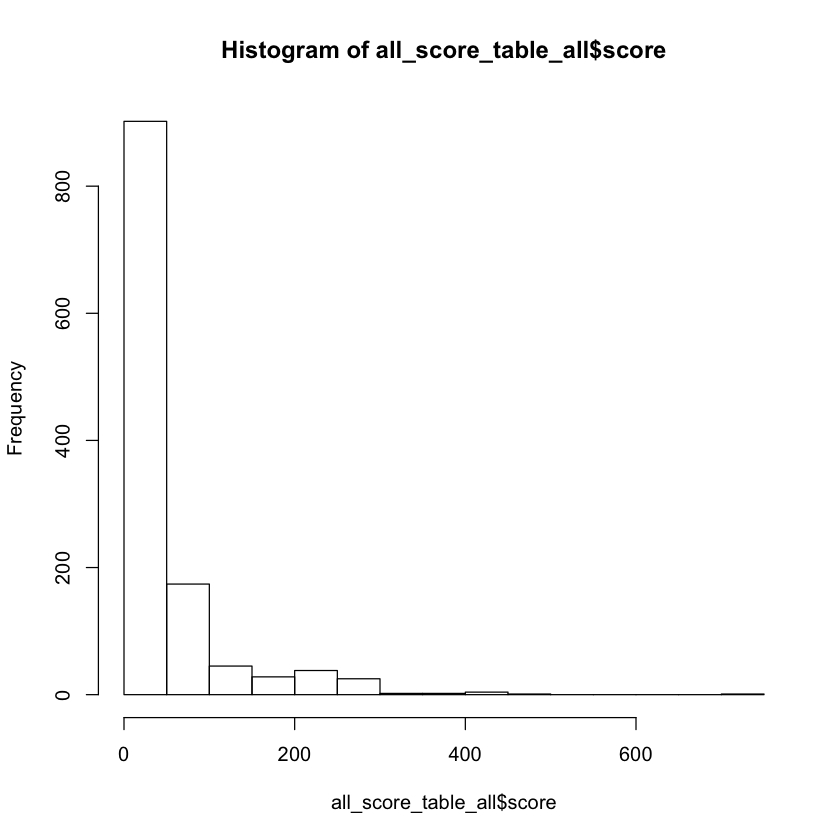

In [56]:
hist(all_score_table_all$score)
min(all_score_table_all$score)
mean(all_score_table_all$score)
median(all_score_table_all$score)

[1] 18

[1] 37.995

[1] 36

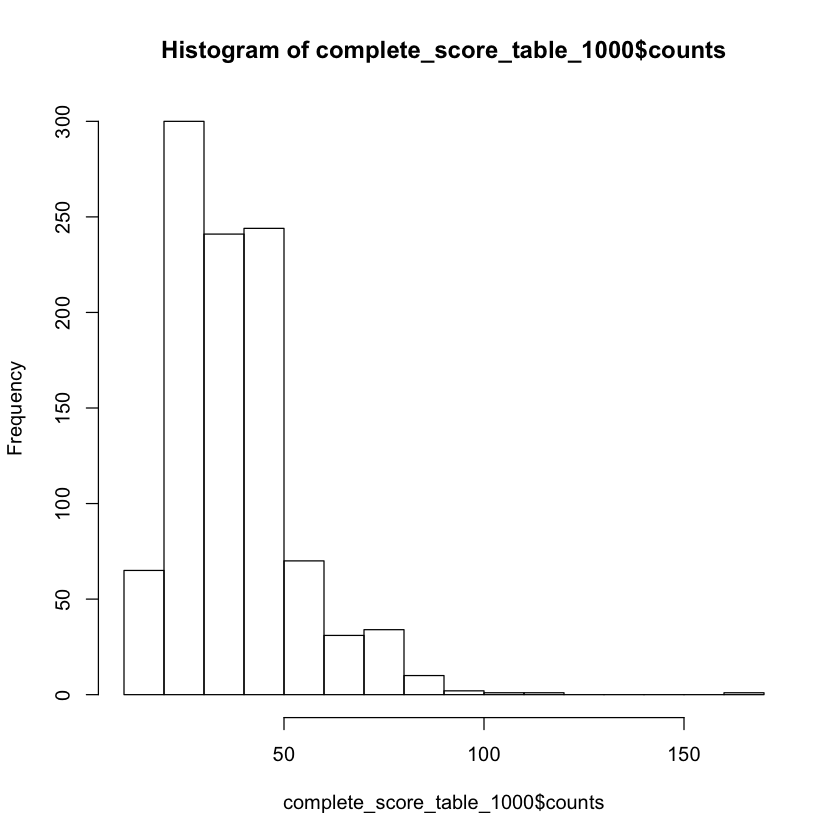

In [199]:
hist(complete_score_table_1000$counts)
min(complete_score_table_1000$counts)
mean(complete_score_table_1000$counts)
median(complete_score_table_1000$counts)

In [16]:
length(intersect(random_table$V1, complete_score_table_50$gene))
length(intersect(random_table$V1, complete_score_table_100$gene))
length(intersect(random_table$V1, complete_score_table_500$gene))
length(intersect(random_table$V1, complete_score_table_1000$gene))

length(intersect(random_table$V1[1:50], complete_score_table_500$gene))
length(intersect(random_table$V1[1:100], complete_score_table_500$gene))
length(intersect(random_table$V1[1:500], complete_score_table_500$gene))

length(intersect(random_table$V1, all_score_table_50$gene))
length(intersect(random_table$V1, all_score_table_100$gene))
length(intersect(random_table$V1, all_score_table_500$gene))
length(intersect(random_table$V1, all_score_table_1000$gene))

length(intersect(random_table$V1[1:50], all_score_table_500$gene))
length(intersect(random_table$V1[1:100], all_score_table_500$gene))
length(intersect(random_table$V1[1:500], all_score_table_500$gene))

length(intersect(random_table$V1, test_score_table[1:50,]$gene))
length(intersect(random_table$V1, test_score_table[1:100,]$gene))
length(intersect(random_table$V1, test_score_table[1:500,]$gene))
length(intersect(random_table$V1, test_score_table[1:1000,]$gene))

length(intersect(random_table$V1[1:50], test_score_table[1:500,]$gene))
length(intersect(random_table$V1[1:100], test_score_table[1:500,]$gene))
length(intersect(random_table$V1[1:500], test_score_table[1:500,]$gene))

length(intersect(all_score_table_50$gene, complete_score_table_50$gene))
length(intersect(all_score_table_100$gene, complete_score_table_100$gene))
length(intersect(all_score_table_500$gene, complete_score_table_500$gene))
length(intersect(all_score_table_1000$gene, complete_score_table_1000$gene))

ERROR: Error in intersect(random_table$V1, complete_score_table_50$gene): object 'complete_score_table_50' not found


In [23]:
# all ASD genes possible
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/rASDgenes/rASDgenes.rda")
sfariAtts = sfariAtts_1

# all gene possible
allProteinCodingGenes = allProteinCodingGenes[allProteinCodingGenes %in% as.character(gene_all) ]

# all features selected
gene_selected = c()
dim(sfariAtts)
for(i in c(1:6)){
gNet = as.character(a_list[[i]]$gene)
common = intersect(gNet, sfariAtts$Entrez_Gene_ID)
    print(length(common))
gene_selected = c(gene_selected,common)
print(sum(dhyper(length(common):length(gNet),nrow(sfariAtts),length(allProteinCodingGenes)-nrow(sfariAtts),length(gNet))))
}
# print("enrichment for all possible ASD gene")
unique(gene_selected)


[1] 625   4

[1] 27
[1] 0.5068172
[1] 26
[1] 0.5877573
[1] 27
[1] 0.5068172
[1] 28
[1] 0.4264974
[1] 40
[1] 0.9828613
[1] 62
[1] 0.8865853


[1] "57595"  "4306"   "114783" "7850"   "3458"   "596"    "6907"   "23135" 
 [9] "22846"  "1523"   "1387"   "463"    "79143"  "2171"   "6772"   "481"   
[17] "4650"   "6601"   "2932"   "2944"   "4335"   "10964"  "221037" "7528"  
[25] "51111"  "130074" "53615"  "10651"  "9256"   "3678"   "64207"  "134957"
[33] "9898"   "79893"  "6942"   "5253"   "2033"   "4173"   "26047"  "5294"  
[41] "9295"   "3728"   "55690"  "129607" "5816"   "64744"  "9123"   "253980"
[49] "29997"  "23152"  "23030"  "8527"   "5211"   "8666"   "9783"   "23515" 
[57] "9236"   "23295"  "89801"  "23312"  "55015"  "57471"  "6196"   "55236" 
[65] "3356"   "4784"   "57634"  "4208"   "115"    "254048" "5595"   "23211" 
[73] "1977"   "10765"  "3720"   "6448"   "32"

In [76]:
# write.csv(sfariAtts[sfariAtts$Entrez_Gene_ID %in% unique(gene_selected),], "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/possible_ASD.txt")
# write.csv(sfariAtts[sfariAtts$Entrez_Gene_ID %in% unique(gene_selected),], "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/possible_ASD_random.txt")

In [92]:
.myNetGeneExtractorFn=function(inputNet){
  #This functions retruns the list of genes that are present in the input network
  #inputNet: input network that is expected to have gene names in Fnode and Snode columns
  genelist=unique(c(as.character(inputNet$Fnode),as.character(inputNet$Snode)))
  return(genelist)
}

# 3.1 gene enrichment test for brainSpan

In [61]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/brainSpan/brianSpanRNAseq.rda")
dataBSrnaSeq=brainSpanRNAseq
rm(brainSpanRNAseq)
names(pData(dataBSrnaSeq))

names(pData(dataBSrnaSeq))[which(names(pData(dataBSrnaSeq))=="donor_name")]="brainCode"

names(pData(dataBSrnaSeq))[which(names(pData(dataBSrnaSeq))=="structure_acronym")]="brainRegion"

#Organizing the age data of brainSpan dataset
pData(dataBSrnaSeq)$age=as.character(pData(dataBSrnaSeq)$age)
x=regexpr(" ",pData(dataBSrnaSeq)$age)
ageNo=substr(pData(dataBSrnaSeq)$age,0,x-1)
unit=substr(pData(dataBSrnaSeq)$age,x+1,nchar(pData(dataBSrnaSeq)$age))
pData(dataBSrnaSeq)$age=as.numeric(ageNo)
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),ageUnit=unit)
rm(ageNo,unit,x)

regionsGrouped=as.character(pData(dataBSrnaSeq)$brainRegion)
regionsMega=as.character(pData(dataBSrnaSeq)$brainRegion)

#Grouping the brain regions
regionsGrouped[regionsGrouped %in% c("OFC","DFC","VFC","MFC","M1C","FC",'M1C_S1C')]="FC"
regionsGrouped[regionsGrouped %in% c("PCx","S1C","IPC")]="PC"
regionsGrouped[regionsGrouped %in% c("TCx","A1C","ITC","STC")]="TC"
regionsGrouped[regionsGrouped %in% c("Ocx","V1C")]="OC"
#Defining mega groups
regionsMega[regionsMega %in% c('OFC','DFC','VFC','MFC','M1C','S1C','IPC','A1C','STC','ITC','V1C','M1C_S1C')]="neocortex"
regionsMega[!(regionsMega %in% c('neocortex'))]="other"
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),brainRegionsGrouped=regionsGrouped,brainRegionsMega=regionsMega)

pData(dataBSrnaSeq)$brainRegionsGrouped=as.factor(pData(dataBSrnaSeq)$brainRegionsGrouped)
pData(dataBSrnaSeq)$brainRegionsMega=as.factor(pData(dataBSrnaSeq)$brainRegionsMega)

pData(dataBSrnaSeq)$ageManaged=paste0(pData(dataBSrnaSeq)$age,".",as.character(pData(dataBSrnaSeq)$ageUnit))
pData(dataBSrnaSeq)$ageManaged=factor(pData(dataBSrnaSeq)$ageManaged,levels=c("8.pcw","9.pcw","12.pcw","13.pcw","16.pcw","17.pcw","19.pcw","21.pcw","24.pcw","25.pcw","26.pcw","35.pcw","37.pcw","4.mos","10.mos","1.yrs","2.yrs","3.yrs","4.yrs","8.yrs","11.yrs","13.yrs","15.yrs","18.yrs","19.yrs","21.yrs","23.yrs","30.yrs","36.yrs","37.yrs","40.yrs"))

#Defining critical age periods of brain development
x=(pData(dataBSrnaSeq)$age>=8&pData(dataBSrnaSeq)$ageUnit=="pcw")+(pData(dataBSrnaSeq)$ageUnit=="mos")
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),ageAutismSensitive=x)

x=(pData(dataBSrnaSeq)$age>4&pData(dataBSrnaSeq)$ageUnit=="yrs")
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),ageAfter4=x)

x=as.numeric(pData(dataBSrnaSeq)$ageUnit=="pcw")
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),agePCW=x)

x=(pData(dataBSrnaSeq)$age>4&pData(dataBSrnaSeq)$age<20&pData(dataBSrnaSeq)$ageUnit=="Y")
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),age4_20=x)

x=(pData(dataBSrnaSeq)$age>20&pData(dataBSrnaSeq)$age<40&pData(dataBSrnaSeq)$ageUnit=="Y")
pData(dataBSrnaSeq)=cbind(pData(dataBSrnaSeq),age20_40=x)

#Collapsing the data at entrez GeneID level
x=base::rowMeans(exprs(dataBSrnaSeq))
o <- order(x, decreasing=TRUE)
dataBSrnaSeq <- dataBSrnaSeq[o,]
dataBSrnaSeq <- dataBSrnaSeq[!duplicated(fData(dataBSrnaSeq)$entrez_id),]
dataBSrnaSeq=dataBSrnaSeq[!is.na(fData(dataBSrnaSeq)$entrez_id)]
rm(x)
rm(o)

row.names(dataBSrnaSeq)=fData(dataBSrnaSeq)$entrez_id
fData(dataBSrnaSeq)$Entrez_Gene_ID=fData(dataBSrnaSeq)$entrez_id
rm(regionsGrouped,regionsMega)

[1] "column_num"        "donor_id"          "donor_name"       
[4] "age"               "gender"            "structure_id"     
[7] "structure_acronym" "structure_name"    "subjectId"

In [ ]:
# # 3.2 GSEA based GO enrichment analysis of the networks
# #GSEA analysis
# First geneset enrichment analysis (GSEA) was performed on the dataset (ASD vs TD). Next, the DE-ASD networks were tested for the significant overlaps with the terms that were deemed as significant by GSEA.

[1] 459

[1] 465

[1] 882

[1] 926

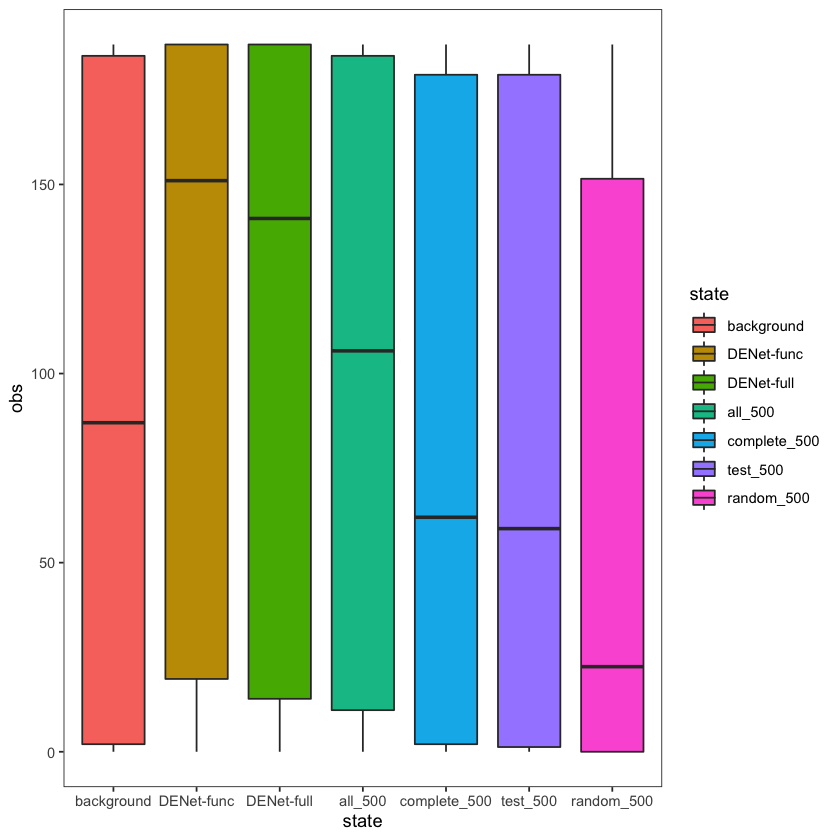

In [64]:
x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% complete_score_table[1:500,]$gene,pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
x=exprs(x)>5
x=apply(x,1,sum)
length(x)
tmpDf=data.frame(state="complete_500",obs=x, stringsAsFactors = F)

x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% all_score_table[1:500,]$gene, pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
x=exprs(x)>5
x=apply(x,1,sum)
length(x)
tmpDf=rbind(tmpDf,data.frame(state="all_500",obs=x,stringsAsFactors = F))

x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% random_table[1:500,]$gene,pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
x=exprs(x)>5
x=apply(x,1,sum)
tmpDf=rbind(tmpDf,data.frame(state="random_500",obs=x,stringsAsFactors = F))

x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% test_score_table[1:500,]$gene,pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
x=exprs(x)>5
x=apply(x,1,sum)
tmpDf=rbind(tmpDf,data.frame(state="test_500",obs=x,stringsAsFactors = F))

x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% .myNetGeneExtractorFn(netFuncGeneManiaMProband),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
x=exprs(x)>5
x=apply(x,1,sum)
length(x)
tmpDf=rbind(tmpDf,data.frame(state="DENet-func",obs=x,stringsAsFactors = F))

x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% .myNetGeneExtractorFn(netFullMProbandCombined),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
x=exprs(x)>5
x=apply(x,1,sum)
length(x)
tmpDf=rbind(tmpDf,data.frame(state="DENet-full",obs=x,stringsAsFactors = F))

tst=exprs(dataBSrnaSeq)
tst=tst[row.names(dataBSrnaSeq) %in% as.character(allProteinCodingGenes),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
tst=tst>5
tst=apply(tst,1,sum)
tmpDf=rbind(tmpDf,data.frame(state="background",obs=tst,stringsAsFactors = F))

tmpDf$state=factor(tmpDf$state,levels=c("background",
                                          "DENet-func",
                                          "DENet-full",
                                          'all_500',
                                          'complete_500',
                                          'test_500',
                                          'random_500'))
# pdf(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/brainSpan_neural_dev.pdf",width = 8, height = 6)
p=ggplot(data=tmpDf,aes(state,obs,fill=state))
p+geom_boxplot()+theme_bw()+theme(panel.grid = element_blank())
# dev.off()

In [179]:
length(allProteinCodingGenes)

[1] 11695

In [175]:
# # load("/Volumes/Work/r_note/asd_transcriptional_organization-master/network.rda")
# # should customize the gene entrez_id with 
# x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% .myNetGeneExtractorFn(netMProbandCombined),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]

# x=exprs(x)>5
# x=apply(x,1,sum)
# length(x)
# tmpDf=data.frame(state="DENet-hc",obs=x,stringsAsFactors = F)

# x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% .myNetGeneExtractorFn(netFuncGeneManiaMProband),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
# x=exprs(x)>5
# x=apply(x,1,sum)
# length(x)
# tmpDf=rbind(tmpDf,data.frame(state="DENet-func",obs=x,stringsAsFactors = F))

# x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% .myNetGeneExtractorFn(netFullMProbandCombined),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
# x=exprs(x)>5
# x=apply(x,1,sum)
# length(x)
# tmpDf=rbind(tmpDf,data.frame(state="DENet-full",obs=x,stringsAsFactors = F))

# x=dataBSrnaSeq[row.names(dataBSrnaSeq) %in% row.names(asdProband)[asdProband$adj.P.Val<0.05],pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
# x=exprs(x)>5
# x=apply(x,1,sum)
# length(x)
# tmpDf=rbind(tmpDf,data.frame(state="DEgenes",obs=x,stringsAsFactors = F))

# tst=exprs(dataBSrnaSeq)
# tst=tst[row.names(dataBSrnaSeq) %in% as.character(allProteinCodingGenes),pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1]
# tst=tst>5
# tst=apply(tst,1,sum)
# tmpDf=rbind(tmpDf,data.frame(state="background",obs=tst,stringsAsFactors = F))

# p=ggplot(data=tmpDf,aes(state,obs,fill=state))
# p+geom_boxplot()+theme_bw()+theme(panel.grid = element_blank())

# print("Summary stats on the above boxplot:")
# print(aggregate(obs~state,data=tmpDf,summary))
# print("Number of genes per group in the above boxplot:")
# print(table(tmpDf$state))
# print(paste("total number of samples per group in the above boxplot:",sum(pData(dataBSrnaSeq)$brainRegionsMega=="neocortex"&pData(dataBSrnaSeq)$ageAutismSensitive==1)))

# #enrichment for DE genes
# x=tmpDf[tmpDf$state %in% c("background","DEgenes"),]
# paste("DE genes p-val:",pnorm(statistic(wilcox_test(obs~as.factor(state),data=x), "standardized")[1]))

# #enrichment for DE-ASD full net
# x=tmpDf[tmpDf$state %in% c("background","DENet-full"),]
# paste("Full DE-ASD net p-val:",pnorm(statistic(wilcox_test(obs~as.factor(state),data=x), "standardized")[1]))

# #enrichment for DE-ASD functional net
# x=tmpDf[tmpDf$state %in% c("background","DENet-func"),]
# paste("Func. DE-ASD net p-val:",pnorm(statistic(wilcox_test(obs~as.factor(state),data=x), "standardized")[1]))

# #enrichment for DE-ASD high confidence net
# x=tmpDf[tmpDf$state %in% c("background","DENet-hc"),]
# paste("HC DE-ASD net p-val:",pnorm(statistic(wilcox_test(obs~as.factor(state),data=x), "standardized")[1]))

# 3.3 enrichemnt analysis for neural differentiation

In [165]:
sum(gene_all %in% row.names(asdProband))

[1] 13581

In [65]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/ASD_iPS_data/expression_data.rda")
##Expression level of genes in DE-ASD networks during neural differentiation

#expression level of DE genes and networks compared to background
print(paste("Number of hiPSC-derived neural progenitor and neuron samples included in the analysis:",ncol(normData)))
bkg=exprs(normData)[row.names(normData) %in% row.names(asdProband) ,]
bkg=bkg[row.names(bkg) %in% gene_all,]

bkg=apply(bkg,1,median)

deGenes=bkg[names(bkg) %in% DEgenes$entrezgene]
deHC=bkg[names(bkg) %in% .myNetGeneExtractorFn(netMProbandCombined)]
deFunc=bkg[names(bkg) %in% .myNetGeneExtractorFn(netFuncGeneManiaMProband)]
deFull=bkg[names(bkg) %in% .myNetGeneExtractorFn(netFullMProbandCombined)]

de_all500=bkg[names(bkg) %in% all_score_table[1:500,]$gene]
de_com500=bkg[names(bkg) %in% complete_score_table[1:500,]$gene]
de_random_500=bkg[names(bkg) %in% random_table[1:500,]$gene]
test_500=bkg[names(bkg) %in% test_score_table[1:500,]$gene]

tmpDf=data.frame(status="background",value=bkg,stringsAsFactors = F)
tmpDf=rbind(tmpDf,data.frame(status="Func. DE-ASD",value=deFunc,stringsAsFactors = F))
tmpDf=rbind(tmpDf,data.frame(status="Full. DE-ASD",value=deFull,stringsAsFactors = F))
tmpDf=rbind(tmpDf,data.frame(status="all_500",value=de_all500,stringsAsFactors = F))
tmpDf=rbind(tmpDf,data.frame(status="com_500",value=de_com500,stringsAsFactors = F))
tmpDf=rbind(tmpDf,data.frame(status="test_500",value=test_500,stringsAsFactors = F))
tmpDf=rbind(tmpDf,data.frame(status="random_500",value=de_random_500,stringsAsFactors = F))

tmpDf$status=factor(tmpDf$status,levels=c("background",
                                          "Func. DE-ASD",
                                          "Full. DE-ASD",
                                          'all_500',
                                          'com_500',
                                          'test_500',
                                          'random_500'))
pdf(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/hiPSC_neural_development.pdf",width = 8, height = 6)
ggplot(tmpDf,aes(status,value,fill=status))+geom_boxplot(alpha=0.5)+theme_bw()+theme(text = element_text(size=17),panel.grid = element_blank())+ggtitle(wilcox.test(deHC,bkg)$p.value)
dev.off()
tmp=t(scale(t(exprs(normData))))
tmp=apply(tmp[row.names(normData) %in% .myNetGeneExtractorFn(netMProbandCombined),],2,median)

df=data.frame(pData(normData),medExp=tmp,stringsAsFactors = F)
df=df[df$cellType %in% c("D0","D2","D4","D7","D14"),]
df$cellType=factor(df$cellType,levels = c("D0","D2","D4","D7","D14"))

[1] "Number of hiPSC-derived neural progenitor and neuron samples included in the analysis: 65"


pdf 
  2

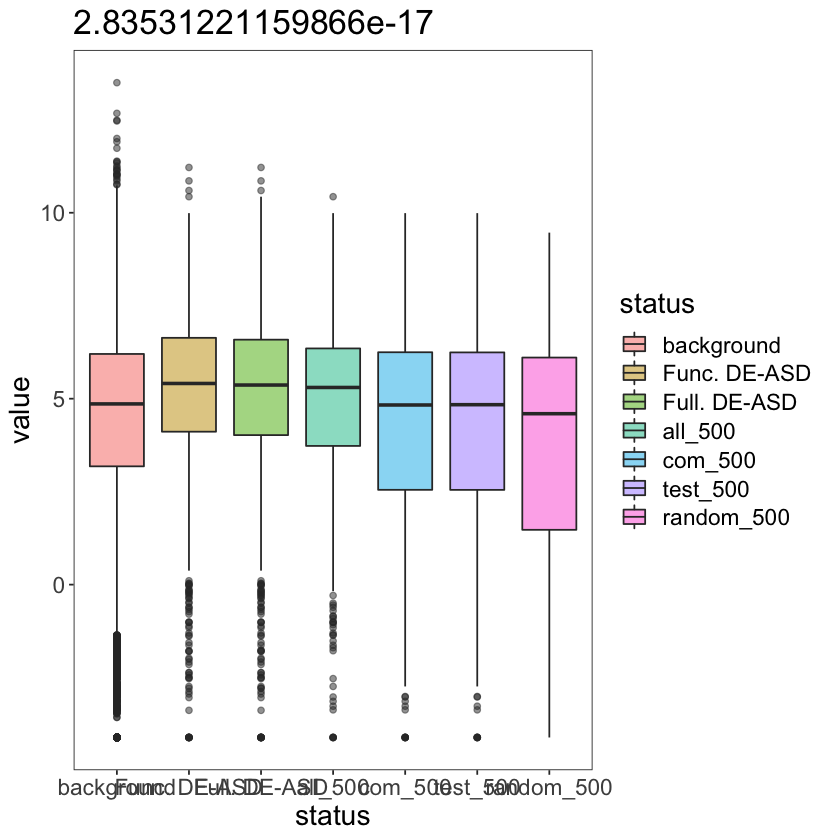

In [66]:
ggplot(tmpDf,aes(status,value,fill=status))+geom_boxplot(alpha=0.5)+theme_bw()+theme(text = element_text(size=17),panel.grid = element_blank())+ggtitle(wilcox.test(deHC,bkg)$p.value)


# 
3.4 gene regulated by rASD gene

In [67]:

.readGeneSetData=function(pathToGeneset, geneLabelsInDataset,nmin,nmax)
{
  #This funciton reads gmt formatted geneset data
  gs.db=pathToGeneset
  gs.size.threshold.min=nmin;
  gs.size.threshold.max=nmax;
  if (regexpr(pattern=".gmt", gs.db[1]) == -1) {
    temp <- gs.db
  } else {
    temp <- readLines(gs.db)
  }
  
  gene.labels=geneLabelsInDataset
  max.Ng <- length(temp)
  temp.size.G <- vector(length = max.Ng, mode = "numeric") 
  
  
  max.size.G <- length(gene.labels)      
  gs <- matrix(rep("null", max.Ng*max.size.G), nrow=max.Ng, ncol= max.size.G)
  temp.names <- vector(length = max.Ng, mode = "character")
  temp.desc <- vector(length = max.Ng, mode = "character")
  for (i in 1:max.Ng) {
    gene.set.size <- length(unlist(strsplit(temp[[i]], "\t"))) - 2
    gs.line <- noquote(unlist(strsplit(temp[[i]], "\t")))
    gene.set.name <- gs.line[1] 
    gene.set.desc <- gs.line[2] 
    gene.set.tags <- vector(length = gene.set.size, mode = "character")
    for (j in 1:gene.set.size) {
      gene.set.tags[j] <- gs.line[j + 2]
    } 
    existing.set <- is.element(gene.labels,gene.set.tags)
    set.size <- length(existing.set[existing.set == T])
    temp.size.G[i] <- set.size
    gs[i,] <- rep("b",length(existing.set))
    gs[i,existing.set]="a"
    temp.names[i] <- gene.set.name
    temp.desc[i] <- gene.set.desc
    
  } 
  rownames(gs)=temp.names
  colnames(gs)=gene.labels
  
  finalRes=gs[temp.size.G>nmin&temp.size.G<nmax,]
  
  return(finalRes)
}
.myORfn=function(inputNetGenes,inputGS,backgroundGenes,inputNetGenesName="a"){
  
  inputNetGenes=intersect(as.character(inputNetGenes),as.character(backgroundGenes))
  
  bkgLength=length(backgroundGenes)
  inputGS=inputGS[,colnames(inputGS) %in% backgroundGenes]
  
  tmpDf=data.frame(gs="a",netName=inputNetGenesName,OR=1,stringsAsFactors = F)
  for(i in 1:nrow(inputGS)){
    tmpGs=colnames(inputGS)[inputGS[i,]=="a"]
    
    df=data.frame(gene=backgroundGenes,stringsAsFactors = F)
    df$GS="No"
    df$GS[df$gene %in% tmpGs]="Yes"
    df$net="No"
    df$net[df$gene %in% inputNetGenes]="Yes"
    
    tmpOR=fisher.test(table(df$GS,df$net))$estimate
    
    tmpDf=rbind(tmpDf,data.frame(gs=row.names(inputGS)[i],netName=inputNetGenesName,OR=tmpOR,stringsAsFactors = F))
    rm(tmpGs,df,tmpOR)
    
  }
  tmpDf=tmpDf[-1,]
  return(tmpDf)
}
.myPermTest=function(inputNetGenes,inputGS,backgroundGenes,inputNetGenesName="a"){
  set.seed=12345 #to make the permutaiton reproducible
  
  inputNetGenes=intersect(as.character(inputNetGenes),as.character(backgroundGenes))
  
  bkgLength=length(backgroundGenes)
  inputGS=inputGS[,colnames(inputGS) %in% backgroundGenes]
  #inputNetGenesName="HC DE_Net"
  
  tmpDf=data.frame(gs="a",netName=inputNetGenesName,pvalue=0,empPval=0,gsLength=0,stringsAsFactors = F)
  for(i in 1:nrow(inputGS)){
    tmpGs=colnames(inputGS)[inputGS[i,]=="a"]
    tmpGSlength=length(tmpGs)
    common=length(intersect(tmpGs,inputNetGenes))
    minVal=min(length(tmpGs),length(inputNetGenes))
    maxVal=max(length(tmpGs),length(inputNetGenes))
    pval=sum(dhyper(common:minVal,maxVal,bkgLength-maxVal,minVal))
    
    res=0
    for(ii in 1:10000){
      tst=sample(backgroundGenes,length(inputNetGenes),replace = F)
      res=c(res,length(intersect(tmpGs,tst)))
    }
    if(sum(res>(common-1))<5){
      for(ii in 1:90000){
      tst=sample(backgroundGenes,length(inputNetGenes),replace = F)
      res=c(res,length(intersect(tmpGs,tst)))
    }
    }
    res=res[-1]
    empricalPval=sum(res>(common-1))/length(res)
    tmpDf=rbind(tmpDf,data.frame(gs=row.names(inputGS)[i],netName=inputNetGenesName,pvalue=pval,empPval=empricalPval,gsLength=tmpGSlength,stringsAsFactors = F))
    
    
  }
  tmpDf=tmpDf[-1,]
  return(tmpDf)
}

In [ ]:
#Overlap of DE-ASD networks with co-expression modules during brain development
gsData=.readGeneSetData("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/GeneSets/geneSetsAutism.gmt",allProteinCodingGenes,10,100000)

exclusions=c("chd8dwnPval","chd8dwnFDR","CHD8-chip-sugathan","chd8upPval","CHD8-shRNAi-G-up","chd8upFDR","CHD8-chip-cotney","FMRP-Darnell","CHD8-shRNAi","chd8FDR","CHD8-shRNAi-down","CHD8-shRNAi-up")
gsData=gsData[!(row.names(gsData) %in% exclusions),]

gNet=all_score_table_500$gene
gNetFuncGeneMania=complete_score_table_500$gene
gNetFull=test_score_table[1:500,]$gene

pvalRes=.myPermTest(gNet,gsData,allProteinCodingGenes,"HC DE_Net")
pvalRes2=.myPermTest(gNetFuncGeneMania,gsData,allProteinCodingGenes,"Func. DE_Net geneMania")
pvalRes3=.myPermTest(gNetFull,gsData,allProteinCodingGenes,"Full DE_Net")

x=merge(pvalRes,pvalRes2,by="gs")
colnames(x)=c("gs","netName.x","pvalueDEhc","empPvalDEhc","length","netName.y","pvalueDEfuncGeneMania","empPvalDEfuncGeneMania","length.y")
x=merge(x,pvalRes3,by="gs")
colnames(x)=c("gs","netName.x","pvalueDEhc","empPvalDEhc","length","netName.y","pvalueDEfuncGeneMania","empPvalDEfuncGeneMania","length.y","netName.z","pvalueDEfull","empPvalDEfull","length.z")

if(sum(x$empPvalDEhc==0)>0){
  x$empPvalDEhc[x$empPvalDEhc==0]=x$pvalueDEhc[x$empPvalDEhc==0]
}

if(sum(x$empPvalDEfuncGeneMania==0)>0){
  x$empPvalDEfuncGeneMania[x$empPvalDEfuncGeneMania==0]=x$pvalueDEfunc[x$empPvalDEfuncGeneMania==0]
}

if(sum(x$empPvalDEfull==0)>0){
  x$empPvalDEfull[x$empPvalDEfull==0]=x$pvalueDEfull[x$empPvalDEfull==0]
}


x$FDRempDEhc=p.adjust(x$empPvalDEhc,method="BH")
x$FDRdeHC=p.adjust(x$pvalueDEhc,method="BH")

x$FDRempDEfuncGeneMania=p.adjust(x$empPvalDEfuncGeneMania,method="BH")
x$FDRdeFuncGeneMania=p.adjust(x$pvalueDEfuncGeneMania,method="BH")

x$FDRempDEfull=p.adjust(x$empPvalDEfull,method="BH")
x$FDRdeFull=p.adjust(x$pvalueDEfull,method="BH")

x$color="otherModules"
x$color[x$gs %in% c("all_genes_in_network","net3_5_willsey","net4_6_willsey")]="NetrASD"
x$color[x$gs %in% c("M13-parikshak","M16-parikshak","M3-parikshak","M2-parikshak","M17-parikshak")]="MrASD"


In [ ]:
pdf(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/brain_co_expression.pdf",width = 8, height = 6)
dev.off()
x$border="nonesig"
x$border[x$FDRempDEhc<0.1&x$FDRempDEfuncGeneMania<0.1]="significant"
p=ggplot(x,aes(length,-log10(empPvalDEhc),fill=color,alpha=border))
p=p+geom_jitter(data=x[x$border=="nonesig",],aes(length,-log10(empPvalDEhc)),width=0.05,height=0.1,size=3,pch=21)
p=p+geom_jitter(data=x[x$border!="nonesig",],aes(length,-log10(empPvalDEhc),color=border),width=0.05,height=0.1,size=4.5,color="#fc7202",pch=21,stroke=1.5)+theme_bw()+theme(text = element_text(size=17),panel.grid=element_blank())+scale_fill_manual(values = c(otherModules="black",NetrASD="limegreen",MrASD="dodgerblue"))
p=p+scale_y_continuous(breaks = seq(-1,6,1))+scale_alpha_manual(values = c(significant=1,nonesig=0.5))+xlab("Module size")+ylab("P-value\nHigh confidence DE-ASD")
p
dev.off()

In [73]:
#DE-ASD networks are regulated by rASD genes
##Enrichment of DE-ASD networks for the known regulatory targets of rASD genes
gsData=.readGeneSetData("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/GeneSets/geneSetsAutism.gmt",allProteinCodingGenes,10,100000)
exclusions=c("M1-parikshak","M4-parikshak","M5-parikshak","M6-parikshak","M8-parikshak","M9-parikshak","M10-parikshak","M11-parikshak","M12-parikshak","M18-parikshak","M17-parikshak","M15-parikshak","net3_5_willsey","net4_6_willsey","M3-parikshak","M2-parikshak","M16-parikshak","M13-parikshak","M14-parikshak","all_genes_in_network","chd8upFDR","chd8upPval","chd8dwnPval","chd8dwnFDR","CHD8-shRNAi-up","CHD8-shRNAi-down","CHD8-shRNAi","chd8FDR","CHD8_down_mice_fdr0.1","CHD8_up_mice_fdr0.1")

gsData=gsData[!(row.names(gsData) %in% exclusions),]
gNet=.myNetGeneExtractorFn(netMProbandCombined)
gNetFunc=.myNetGeneExtractorFn(netFuncGeneManiaMProband)

ORres=.myORfn(gNet,gsData,allProteinCodingGenes,"DENet-HC")
ORres=rbind(ORres,.myORfn(gNetFunc,gsData,allProteinCodingGenes,"DENet-funcGeneMania"))
 # ORres=rbind(ORres,.myORfn(all_score_table_50$gene,gsData,allProteinCodingGenes,"all_50"))
 # ORres=rbind(ORres,.myORfn(all_score_table_100$gene,gsData,allProteinCodingGenes,"all_100"))
ORres=rbind(ORres,.myORfn(all_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"all_500"))
# ORres=rbind(ORres,.myORfn(test_score_table[1:88,]$gene,gsData,allProteinCodingGenes,"test_88"))
# ORres=rbind(ORres,.myORfn(test_score_table[1:165,]$gene,gsData,allProteinCodingGenes,"test_165"))
 # ORres=rbind(ORres,.myORfn(complete_score_table_50$gene,gsData,allProteinCodingGenes,"com_50"))
 # ORres=rbind(ORres,.myORfn(complete_score_table_100$gene,gsData,allProteinCodingGenes,"com_100"))
ORres=rbind(ORres,.myORfn(complete_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"com_500"))
# ORres=rbind(ORres,.myORfn(complete_score_table_1000$gene,gsData,allProteinCodingGenes,"com_1000"))
ORres=rbind(ORres,.myORfn(test_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"test_500"))
ORres=rbind(ORres,.myORfn(de_main_table[1:500,]$gene,gsData,allProteinCodingGenes,"de_500"))

pvalRes=.myPermTest(gNet,gsData,allProteinCodingGenes,"DENet-HC")
pvalRes=rbind(pvalRes,.myPermTest(gNetFunc,gsData,allProteinCodingGenes,"DENet-funcGeneMania"))
 # pvalRes=rbind(pvalRes,.myPermTest(all_score_table_50$gene,gsData,allProteinCodingGenes,"all_50"))
 # pvalRes=rbind(pvalRes,.myPermTest(all_score_table_100$gene,gsData,allProteinCodingGenes,"all_100"))
pvalRes=rbind(pvalRes,.myPermTest(all_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"all_500"))
 # pvalRes=rbind(pvalRes,.myPermTest(complete_score_table_50$gene,gsData,allProteinCodingGenes,"com_50"))
 # pvalRes=rbind(pvalRes,.myPermTest(complete_score_table_100$gene,gsData,allProteinCodingGenes,"com_100"))
pvalRes=rbind(pvalRes,.myPermTest(complete_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"com_500"))
# pvalRes=rbind(pvalRes,.myPermTest(complete_score_table_1000$gene,gsData,allProteinCodingGenes,"com_1000"))
pvalRes=rbind(pvalRes,.myPermTest(test_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"test_500"))
pvalRes=rbind(pvalRes,.myPermTest(de_main_table[1:500,]$gene,gsData,allProteinCodingGenes,"de_500"))




In [74]:
pvalRes

,gs,netName,pvalue,empPval,gsLength
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2,CHD8-chip-cotney,DENet-HC,4.695468e-03,0.00450,1694
3,CHD8-chip-sugathan,DENet-HC,5.716070e-05,0.00005,4709
4,FMRP-Darnell,DENet-HC,4.870299e-05,0.00004,569
5,CHD8_chipSeq_mice,DENet-HC,4.193429e-05,0.00002,565
21,CHD8-chip-cotney,DENet-funcGeneMania,2.186954e-02,0.02270,1694
31,CHD8-chip-sugathan,DENet-funcGeneMania,2.598102e-02,0.02430,4709
41,FMRP-Darnell,DENet-funcGeneMania,5.336530e-03,0.00530,569
51,CHD8_chipSeq_mice,DENet-funcGeneMania,2.935401e-03,0.00290,565
22,CHD8-chip-cotney,all_500,3.723188e-01,0.36890,1694


In [76]:
pvalRes$gs=factor(pvalRes$gs,levels=rev(c("CHD8-chip-cotney","CHD8-chip-sugathan","CHD8_chipSeq_mice","FMRP-Darnell")))
pvalRes$empPval[pvalRes$empPval==0]=pvalRes$pvalue[pvalRes$empPval==0]
pvalRes$netName=factor(pvalRes$netName,levels=c("DENet-HC",
                                                "DENet-funcGeneMania",#"DENet-full",
#                                                 'de_all50',
#                                                 'de_all100',
                                                'all_500',
#                                                 'de_com50',
#                                                 'de_com100',
                                                'com_500',
#                                                 'com_1000',
                                                'test_500',
                                                'random_500'
                                               ))
ORres$gs=factor(ORres$gs,levels=c("CHD8-chip-cotney","CHD8-chip-sugathan","CHD8_chipSeq_mice","FMRP-Darnell"))
ORres$netName=factor(ORres$netName,levels=c("DENet-HC",
                                                "DENet-funcGeneMania",
                                                'all_500',
                                                'com_500',
                                                'test_500',
                                                'random_500'
                                               ))

pdf 
  2

pdf 
  2

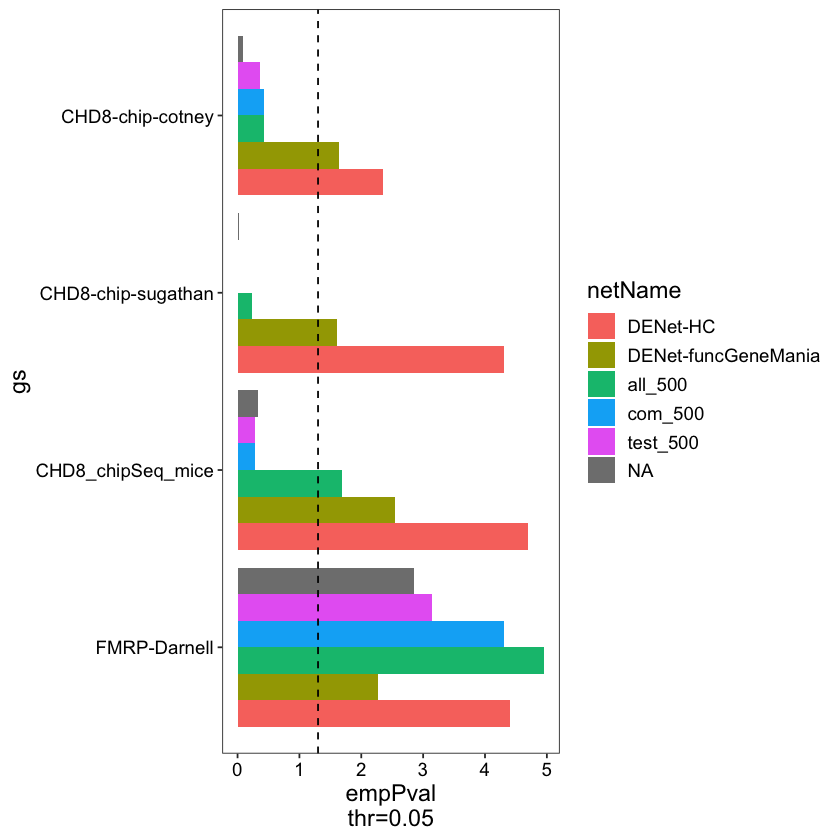

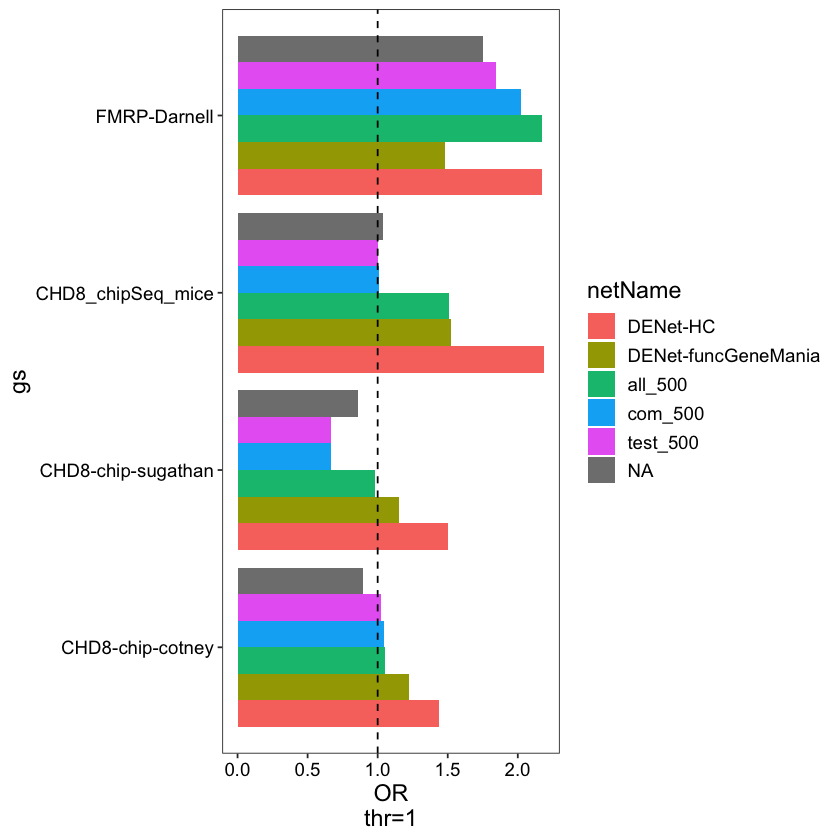

In [77]:
# load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/CompiledData/Fig3AenrichmentResWithFullNet.rda")
pdf(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/regular_pval.pdf",width = 8, height = 6)

p=ggplot(data=pvalRes,aes(gs,-log10(empPval),fill=netName))
p=p+geom_bar(stat="identity",position='dodge')+geom_hline(yintercept = -log10(0.05),linetype="dashed")
p+theme_bw()+theme(text = element_text(size=14),panel.grid = element_blank(),axis.text = element_text(color="black"))+coord_flip()+ylab("empPval\nthr=0.05")
dev.off()
p=ggplot(data=pvalRes,aes(gs,-log10(empPval),fill=netName))
p=p+geom_bar(stat="identity",position='dodge')+geom_hline(yintercept = -log10(0.05),linetype="dashed")
p+theme_bw()+theme(text = element_text(size=14),panel.grid = element_blank(),axis.text = element_text(color="black"))+coord_flip()+ylab("empPval\nthr=0.05")

pdf(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/regular_ORres.pdf",width = 8, height = 6)
p=ggplot(data=ORres,aes(gs,OR,fill=netName))
p=p+geom_bar(stat="identity",position='dodge')+geom_hline(yintercept = 1,linetype="dashed")
p+theme_bw()+theme(text = element_text(size=14),panel.grid = element_blank(),axis.text = element_text(color="black"),)+coord_flip()+ylab("OR\nthr=1")
dev.off()
p=ggplot(data=ORres,aes(gs,OR,fill=netName))
p=p+geom_bar(stat="identity",position='dodge')+geom_hline(yintercept = 1,linetype="dashed")
p+theme_bw()+theme(text = element_text(size=14),panel.grid = element_blank(),axis.text = element_text(color="black"),)+coord_flip()+ylab("OR\nthr=1")

# rm(pvalRes,p,ORres)

In [259]:
write.table(allProteinCodingGenes, file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/background_gene.txt")

ERROR: Error in write.table(allProteinCodingGenes, file = "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/background_gene.txt", : unused argument (index = F)


# Identification of potential regulators of DE-ASD networks through overlap analysis with ENCODE and ChEA-2016 databases


# XP-ASD networks are enriched for rASD genes with gene regulatory roles


In [ ]:
#XP-ASD networks are enriched for rASD genes with gene regulatory roles

load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/rASDgenes/rASDgenes.rda")
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/humanGeneRegulatorsList/humanDNARegGenes.rda")
sfariAtts$isReg="NO"
sfariAtts$isReg[sfariAtts$Entrez_Gene_ID %in% humanDNARegGenes]="YES"

x=data.frame(name=allProteinCodingGenes, isXP="NO",isSfari="NO",isSFARIreg="NO",stringsAsFactors = F)
x$isXP[x$name %in% .myNetGeneExtractorFn(netXPhcProband)]="Yes"
x$isSfari[x$name %in% sfariAtts$Entrez_Gene_ID]="Yes"
x$isSFARIreg[x$name %in% sfariAtts$Entrez_Gene_ID[sfariAtts$isReg=="YES"]]="Yes"


x2=x[x$isSfari=="Yes",]
print(paste("XP-ASD network is significantly enriched for rASD genes with gene regulatory roles. P-value:",fisher.test(table(x2$isSFARIreg,x2$isXP))$p.value,"; OR:",round(fisher.test(table(x2$isXP,x2$isSFARIreg))$estimate,1)))



p1=.myrASDDegreeAnalyzerFn(netXPhcProband,x2$name[x2$isSFARIreg=="Yes"],as.character(sfariAtts$Entrez_Gene_ID),"High confidence XP-ASD",inputBW = 0.4,groupName="Reg. rASD")
p2=.myrASDDegreeAnalyzerFn(netFuncXPgeneManiaProband,x2$name[x2$isSFARIreg=="Yes"],as.character(sfariAtts$Entrez_Gene_ID),"Func. XP-ASD",groupName="Reg. rASD")
p3=.myrASDDegreeAnalyzerFn(netFullXPMProbandCombined,x2$name[x2$isSFARIreg=="Yes"],as.character(sfariAtts$Entrez_Gene_ID),"Full. XP-ASD.",groupName="Reg. rASD")

.myMultiplot(p1,p2,p3,cols = 3)

# GO enrichment

In [78]:
#Biological process enrichment analysis of XP-ASD networks
##GO enrichment
#GO enrichment was assessed by Fishers exact test
.myGOdetailedFn=function(items,inputGene,goTerms,allAnotation,allAnotatedGenes){
  #this function is a sub-function of .myGOenrichmentFn and is not meant to be run separately
  dfRes=data.frame(term="a",description="a",annotated=1,significant=1,pvalFisher=1,isEnriched=0,stringsAsFactors = F)
  for(i in items){
  tmpDesc=unique(goTerms$TERM[goTerms$GOID==i])
  #GOgenes=intersect(unique(select(org.Hs.eg.db, i, "ENTREZID","GOALL")$ENTREZID),allProteinCodingGenes)
  GOgenes <- unique(allAnotation$ENTREZID[which(allAnotation$GOALL==i)])
  if(length(GOgenes)>0){
    cGOgenes=setdiff(allAnotatedGenes,GOgenes)
    common=intersect(GOgenes,inputGene)
    
    pvalHC=fisher.test(rbind(c(length(common),length(GOgenes)-length(common)),c(length(intersect(inputGene,cGOgenes)),length(setdiff(cGOgenes,inputGene)))))$p.value
    
    enrichedHC=fisher.test(rbind(c(length(common),length(GOgenes)-length(common)),c(length(intersect(inputGene,cGOgenes)),length(setdiff(cGOgenes,inputGene)))),alternative = "g")$p.value
    
    dfRes=rbind(dfRes,data.frame(term=i,description=tmpDesc,annotated=length(GOgenes),significant=length(common),pvalFisher=pvalHC,isEnriched=enrichedHC,stringsAsFactors = F))
  }
  }
  dfRes=dfRes[-1,]
  
  return(dfRes)
}
.myGOenrichmentFn=function(inputGene,inputBkg,inputOntology=c("BP","MF","CC"),inputMinNodeSize=9,inputMaxNodeSize=1000,GOall=T){
  #input ontology can be "BP", "CC","MF", and a combination of thereof; e.g., c("MF","BP","CC")
  #if GOALL is off, a limited number of annotated genes will be used for the enrichment test
  #inputGene and inputBkg are supposed to be in gene entrez ids
  
require(org.Hs.eg.db)
require("GO.db")
  
validGoIDs=(keys(org.Hs.eg.db, keytype="GO"))
if(GOall){
allAnotation= AnnotationDbi::select(org.Hs.eg.db,columns = c("ENTREZID","GOALL","ONTOLOGYALL"),keys=as.character(inputBkg),keytypes="ENTREZID")
} else {
  allAnotation= AnnotationDbi::select(org.Hs.eg.db,columns = c("ENTREZID","GO"),keys=as.character(inputBkg),keytypes="ENTREZID")
}

goTerms=AnnotationDbi::select(GO.db, validGoIDs, c("TERM","ONTOLOGY"), "GOID")
goTerms=goTerms[goTerms$ONTOLOGY %in% inputOntology,]

#GOlist=GOlevels[grepl("cell_cycle",GOlevels$description),]
#GOmapper=GOmapper[GOmapper$GO %in% GOlist,]
allAnotatedGenes=allAnotation[allAnotation$GO %in% goTerms$GOID,]
allAnotatedGenes=unique(allAnotatedGenes$ENTREZID)

tst=split(goTerms$GOID,cut(1:length(goTerms$GOID),10))
res=mclapply(tst,.myGOdetailedFn,inputGene,goTerms,allAnotation,allAnotatedGenes,mc.cores = 5)
dfRes <- do.call("rbind", res)

dfRes$isEnriched[dfRes$isEnriched>0.5]=(-1)
dfRes$isEnriched[dfRes$isEnriched>=0]=1
dfRes=dfRes[dfRes$annotated>inputMinNodeSize&dfRes$annotated<inputMaxNodeSize,]

dfRes$fdr=p.adjust(dfRes$pvalFisher,method="fdr")
row.names(dfRes)=dfRes$term
return(dfRes)
}
.myNetGOrunnerFn=function(inputNetDE,inputNetXP,inputrASDgenes){

resXP=.myGOenrichmentFn(.myNetGeneExtractorFn(inputNetXP),allProteinCodingGenes,inputOntology = "BP",inputMaxNodeSize = 2000)
resDE=.myGOenrichmentFn(.myNetGeneExtractorFn(inputNetDE),allProteinCodingGenes,inputOntology = "BP",inputMaxNodeSize = 2000)
resXPsp=.myGOenrichmentFn(intersect(inputrASDgenes,setdiff(.myNetGeneExtractorFn(inputNetXP),.myNetGeneExtractorFn(inputNetDE))),allProteinCodingGenes,inputOntology = "BP",inputMaxNodeSize = 2000)

return(list(DEnet=resDE,XPnet=resXP,XPsp=resXPsp))
}


.myGOcombinerFn=function(inputGOnet,inputNetXP,inputDEgenes,inputrASDgenes){
  inputrASDgenes=intersect(inputrASDgenes,.myNetGeneExtractorFn(inputNetXP))
  inputDEgenes=intersect(inputDEgenes,.myNetGeneExtractorFn(inputNetXP))
  inputDEgo=inputGOnet$DEnet
  inputXPspgo=inputGOnet$XPsp
arranged=merge(inputDEgo,inputXPspgo,by="term")
arranged$pvalFisher.x[arranged$isEnriched.x==(-1)]=1
arranged$pvalFisher.y[arranged$isEnriched.y==(-1)]=1
arranged$ratio=log10(((arranged$significant.x+0.5)/(length(inputDEgenes)+0.5))/((arranged$significant.y+0.5)/(length(inputrASDgenes)+0.5)))
arranged=arranged[-which(colnames(arranged) %in% c("description.y","annotated.y"))]
colnames(arranged)=c("term","description","annotated","significantDE","pvalFisherDE","isEnrichedDE","fdrDE","significantXPsp","pvalFisherXPsp","isEnrichedXPsp","fdrXPsp","ratio")
arranged=arranged[order(arranged$ratio,decreasing = T),]
return(arranged)
}


In [280]:
DEgenes=row.names(asdProband)[asdProband$adj.P.Val<0.05]


In [ ]:
arresHC=.myNetGOrunnerFn(netMProbandCombined,netXPhcProband,sfariAtts$Entrez_Gene_ID)
resFunc=.myNetGOrunnerFn(netFuncGeneManiaMProband,netFuncXPgeneManiaProband,sfariAtts$Entrez_Gene_ID)
resFull=.myNetGOrunnerFn(netFullMProbandCombined,netFullXPMProbandCombined,sfariAtts$Entrez_Gene_ID)
resGO=list(hcNet=resHC,FuncNet=resFunc,FullNet=resFull)
save(resGO,file="CompiledData/resGOfisher.rda")
rm(resHC,resFunc,resFull,resGO)


# load("rawData/rASDgenes/rASDgenes.rda")
# load("CompiledData/resGOfisher.rda")

# slTermsXP=(intersect(resGO$hcNet$XPnet$term[resGO$hcNet$XPnet$fdr<0.1&resGO$FullNet$XPnet$isEnriched==1],c(resGO$FuncNet$XPnet$term[resGO$FuncNet$XPnet$fdr<0.1&resGO$FuncNet$XPnet$isEnriched==1],resGO$FullNet$XPnet$term[resGO$FullNet$XPnet$fdr<0.1&resGO$hcNet$XPnet$isEnriched==1])))

# arrangedXP=merge(resGO$hcNet$XPnet,resGO$FuncNet$XPnet,by="term")
# arrangedXP=merge(arrangedXP,resGO$FullNet$XPnet,by="term")
# colnames(arrangedXP)=c("term","description","annotated","significantHC","pvalFisherHC","isEnrichedHC","fdrHC","descriptionFunc","annotatedFunc","significantFunc","pvalFisherFunc","isEnrichedInFunc","fdrFunc","descriptionFull","annotatedFull","significantFull","pvalFisherFull","isEnrichedInFull","fdr_Full")
# arrangedXP=arrangedXP[arrangedXP$term %in% slTermsXP,]

# rangedFull=.myGOcombinerFn(resGO$FullNet,netFullXPMProbandCombined,DEgenes$entrezgene,sfariAtts$Entrez_Gene_ID)
# arrangedFunc=.myGOcombinerFn(resGO$FuncNet,netFuncXPgeneManiaProband,DEgenes$entrezgene,sfariAtts$Entrez_Gene_ID)
# arrangedHC=.myGOcombinerFn(resGO$hcNet,netXPhcProband,DEgenes$entrezgene,sfariAtts$Entrez_Gene_ID)

# XParrangedFull=arrangedFull[arrangedFull$term %in% slTermsXP,]
# XParrangedFunc=arrangedFunc[arrangedFunc$term %in% slTermsXP,]
# XParrangedHC=arrangedHC[arrangedHC$term %in% slTermsXP,]

# x=merge(arrangedXP,arrangedFull[,c("term",'ratio')])
# colnames(x)[which(colnames(x)=="ratio")]="ratioFull"

# x=merge(x,arrangedFunc[,c("term",'ratio')])
# colnames(x)[which(colnames(x)=="ratio")]="ratioFunc"

# x=merge(x,arrangedHC[,c("term",'ratio')])
# colnames(x)[which(colnames(x)=="ratio")]="ratioHC"

# #extracting the GO tree of the significant terms to cluster similar terms
# GOnet=.myGOtreeFn(x$term,as.character(allProteinCodingGenes))
# GOnet$net=GOnet$net[GOnet$net$Fnode %in% x$term,]
# GOnet$net=GOnet$net[GOnet$net$Snode %in% x$term,]

# Genes up-regulated in k/d of CHD8 risk gene are enriched in DE-ASD networks 
# CHD8 knock-down data were extracted from Sugathan et al. (PMID:25294932), Gompers et al. (PMID:28671691), and Cotney et al. (PMID:25752243) studies.


In [79]:
.readGeneSetData=function(pathToGeneset, geneLabelsInDataset,nmin,nmax)
{
  #This funciton reads gmt formatted geneset data
  gs.db=pathToGeneset
  gs.size.threshold.min=nmin;
  gs.size.threshold.max=nmax;
  if (regexpr(pattern=".gmt", gs.db[1]) == -1) {
    temp <- gs.db
  } else {
    temp <- readLines(gs.db)
  }
  
  gene.labels=geneLabelsInDataset
  max.Ng <- length(temp)
  temp.size.G <- vector(length = max.Ng, mode = "numeric") 
  
  
  max.size.G <- length(gene.labels)      
  gs <- matrix(rep("null", max.Ng*max.size.G), nrow=max.Ng, ncol= max.size.G)
  temp.names <- vector(length = max.Ng, mode = "character")
  temp.desc <- vector(length = max.Ng, mode = "character")
  for (i in 1:max.Ng) {
    gene.set.size <- length(unlist(strsplit(temp[[i]], "\t"))) - 2
    gs.line <- noquote(unlist(strsplit(temp[[i]], "\t")))
    gene.set.name <- gs.line[1] 
    gene.set.desc <- gs.line[2] 
    gene.set.tags <- vector(length = gene.set.size, mode = "character")
    for (j in 1:gene.set.size) {
      gene.set.tags[j] <- gs.line[j + 2]
    } 
    existing.set <- is.element(gene.labels,gene.set.tags)
    set.size <- length(existing.set[existing.set == T])
    temp.size.G[i] <- set.size
    gs[i,] <- rep("b",length(existing.set))
    gs[i,existing.set]="a"
    temp.names[i] <- gene.set.name
    temp.desc[i] <- gene.set.desc
    
  } 
  rownames(gs)=temp.names
  colnames(gs)=gene.labels
  
  finalRes=gs[temp.size.G>nmin&temp.size.G<nmax,]
  
  return(finalRes)
}
.myPermTest=function(inputNetGenes,inputGS,backgroundGenes,inputNetGenesName="a"){
  set.seed=12345 #to make the permutaiton reproducible
  
  inputNetGenes=intersect(as.character(inputNetGenes),as.character(backgroundGenes))
  
  bkgLength=length(backgroundGenes)
  inputGS=inputGS[,colnames(inputGS) %in% backgroundGenes]
  #inputNetGenesName="HC DE_Net"
  
  tmpDf=data.frame(gs="a",netName=inputNetGenesName,pvalue=0,empPval=0,gsLength=0,stringsAsFactors = F)
  for(i in 1:nrow(inputGS)){
    tmpGs=colnames(inputGS)[inputGS[i,]=="a"]
    tmpGSlength=length(tmpGs)
    common=length(intersect(tmpGs,inputNetGenes))
    minVal=min(length(tmpGs),length(inputNetGenes))
    maxVal=max(length(tmpGs),length(inputNetGenes))
    pval=sum(dhyper(common:minVal,maxVal,bkgLength-maxVal,minVal))
    
    res=0
    for(ii in 1:10000){
      tst=sample(backgroundGenes,length(inputNetGenes),replace = F)
      res=c(res,length(intersect(tmpGs,tst)))
    }
    if(sum(res>(common-1))<5){
      for(ii in 1:90000){
      tst=sample(backgroundGenes,length(inputNetGenes),replace = F)
      res=c(res,length(intersect(tmpGs,tst)))
    }
    }
    res=res[-1]
    empricalPval=sum(res>(common-1))/length(res)
    tmpDf=rbind(tmpDf,data.frame(gs=row.names(inputGS)[i],netName=inputNetGenesName,pvalue=pval,empPval=empricalPval,gsLength=tmpGSlength,stringsAsFactors = F))
    
    
  }
  tmpDf=tmpDf[-1,]
  return(tmpDf)
}

In [80]:
## Genes up-regulated in k/d of CHD8 risk gene are enriched in DE-ASD networks 
# CHD8 knock-down data were extracted from Sugathan et al. (PMID:25294932), Gompers et al. (PMID:28671691), and Cotney et al. (PMID:25752243) studies.


# gsData=.readGeneSetData("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/GeneSets/geneSetsAutism.gmt",row.names(asdProband),10,100000)
gsData=.readGeneSetData("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/GeneSets/geneSetsAutism.gmt",allProteinCodingGenes,10,100000)

exclusions=c("M1-parikshak","M4-parikshak","M5-parikshak","M6-parikshak","M8-parikshak","M9-parikshak","M10-parikshak","M11-parikshak","M12-parikshak","M18-parikshak","M17-parikshak","M15-parikshak","net4_6_willsey","net3_5_willsey","M3-parikshak","M2-parikshak","M16-parikshak","M13-parikshak","M14-parikshak","all_genes_in_network","chd8upPval","chd8dwnPval","CHD8-chip-cotney","CHD8-chip-sugathan","FMRP-Darnell","chd8FDR","CHD8-chip-cotney","CHD8-chip-sugathan","FMRP-Darnell",'CHD8-shRNAi',"CHD8_chipSeq_mice")

gsData=gsData[!(row.names(gsData) %in% exclusions),]

gNet=.myNetGeneExtractorFn(netMProbandCombined)
gNetFunc=.myNetGeneExtractorFn(netFuncGeneManiaMProband)

pvalRes=.myPermTest(gNet,gsData,allProteinCodingGenes,"DENet-HC")
pvalRes=rbind(pvalRes,.myPermTest(gNetFunc,gsData,allProteinCodingGenes,"DENet-funcGeneMania"))
pvalRes=rbind(pvalRes,.myPermTest(all_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"all_500"))
 # pvalRes=rbind(pvalRes,.myPermTest(complete_score_table_50$gene,gsData,allProteinCodingGenes,"com_50"))
 # pvalRes=rbind(pvalRes,.myPermTest(complete_score_table_100$gene,gsData,allProteinCodingGenes,"com_100"))
pvalRes=rbind(pvalRes,.myPermTest(complete_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"com_500"))
# pvalRes=rbind(pvalRes,.myPermTest(complete_score_table_1000$gene,gsData,allProteinCodingGenes,"com_1000"))
pvalRes=rbind(pvalRes,.myPermTest(test_score_table[1:500,]$gene,gsData,allProteinCodingGenes,"test_500"))
pvalRes=rbind(pvalRes,.myPermTest(random_table$gene,gsData,allProteinCodingGenes,"random_500"))

pvalRes$gs=factor(pvalRes$gs,levels=rev(c("chd8upFDR","CHD8-shRNAi-up","CHD8_up_mice_fdr0.1","chd8dwnFDR","CHD8-shRNAi-down","CHD8_down_mice_fdr0.1")))
pvalRes$pvalue[pvalRes$pvalue>0.9999]=0.99
pvalRes$empPval[pvalRes$empPval==0]=pvalRes$pvalue[pvalRes$empPval==0]
# save(pvalRes,file="CompiledData/Fig3DenrichmentResWithFullNet.rda")
# rm(pvalRes,gNetFull,gNetFunc,gNet,exclusions,gsData)

In [81]:
pvalRes$netName=factor(pvalRes$netName,levels=c("DENet-HC",
                                                "DENet-funcGeneMania",#"DENet-full",
#                                                 'de_all50',
#                                                 'de_all100',
                                                'all_500',
#                                                 'de_com50',
#                                                 'de_com100',
                                                'com_500',
#                                                 'com_1000',
                                                'test_500',
                                                'random_500'
                                               ))

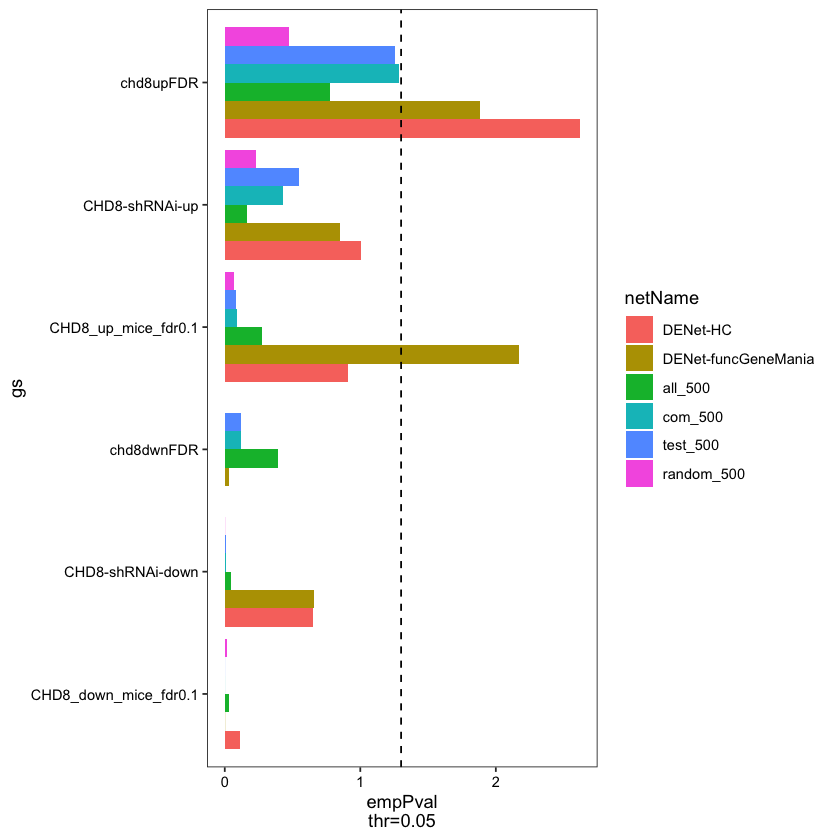

In [82]:
p=ggplot(data=pvalRes,aes(gs,-log10(empPval),fill=netName))
p=p+geom_bar(stat="identity",position='dodge')+geom_hline(yintercept = -log10(0.05),linetype="dashed")
p+theme_bw()+theme(panel.grid = element_blank(),axis.text = element_text(color="black"))+coord_flip()+ylab("empPval\nthr=0.05")


# 3.5 Enrichment test for pathway

In [206]:
.myQQplotFn=function(inputPvals,ci=0.95){
  N  <- length(inputPvals)
  df <- data.frame(
    observed = -log10(sort(inputPvals)),
    expected = -log10(ppoints(N)),
    clower   = -log10(qbeta((1 - ci) / 2, 1:N, N - 1:N + 1)),
    cupper   = -log10(qbeta((1 + ci) / 2, 1:N, N - 1:N + 1))
  )
  return(df)
}
log10Pe <- expression(paste("Expected -log"[10], plain(P)))
log10Po <- expression(paste("Observed -log"[10], plain(P)))

load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/Gene2Pathway/gene2Pathway.rda")



In [253]:

ERKdata=gene2pathway[gene2pathway$target=="ERK",]
ERKdata$isXP="Not_rASD"
sfariAtts=sfariAtts_1
ERKdata$isXP[ERKdata$entrezgene %in% sfariAtts$Entrez_Gene_ID]="Other_rASD"
ERKdata$isXP[ERKdata$entrezgene %in% intersect(all_score_table_all$gene, sfariAtts$Entrez_Gene_ID)]="rASD_selected"
tmp=ERKdata[ERKdata$entrezgene %in% all_score_table_all$gene,]
tmp$isXP="Other_not_ASD"
ERKdata=rbind(ERKdata,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="rASD_selected"])
tmp$status="rASD_selected"
qqRes=tmp

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Other_not_ASD"])
tmp$status="Other_not_ASD"
qqRes=rbind(qqRes,tmp)
 pdf(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/test_all_erk.pdf",width = 8, height = 6)
ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,shape=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(text = element_text(size=14),panel.grid = element_blank())+scale_color_manual(values=c(rASD_selected="red",Other_rASD="green",Not_rASD="black",Other_not_ASD="blue"))+
 ggtitle("ERK pathway",paste("pval:",wilcox.test(ERKdata$Pv[ERKdata$isXP=="Not_rASD"],ERKdata$Pv[ERKdata$isXP=="rASD_selected"])$p.value))
dev.off()

pdf 
  2

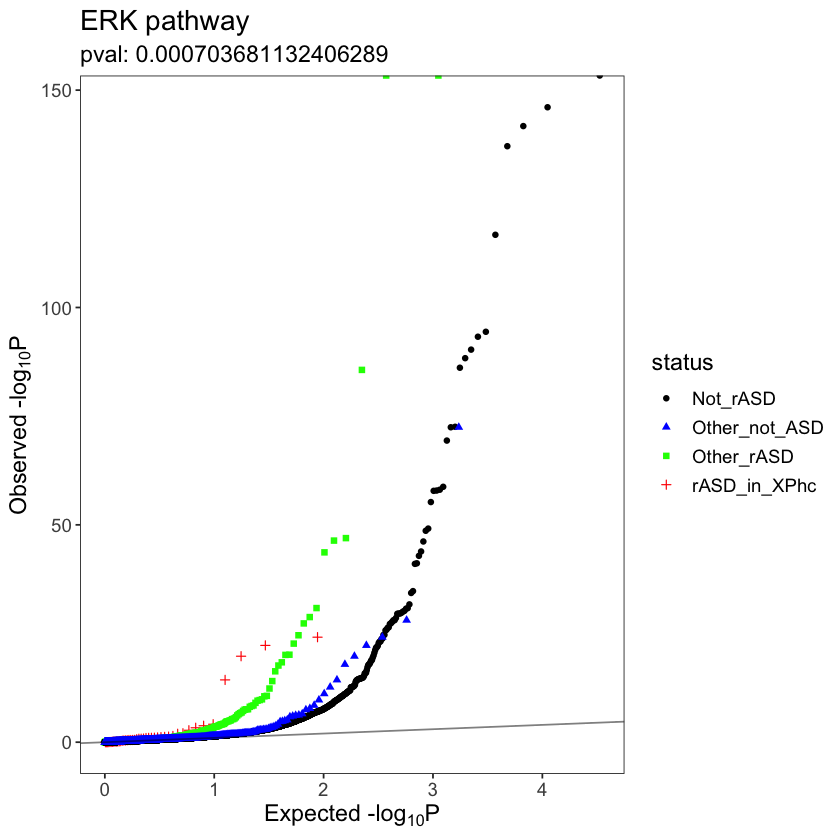

In [255]:

ERKdata=gene2pathway[gene2pathway$target=="ERK",]
ERKdata$isXP="Not_rASD"
sfariAtts=sfariAtts_1
ERKdata$isXP[ERKdata$entrezgene %in% sfariAtts$Entrez_Gene_ID]="Other_rASD"
ERKdata$isXP[ERKdata$entrezgene %in% intersect(complete_score_table_1000$gene, sfariAtts$Entrez_Gene_ID)]="rASD_in_XPhc"
tmp=ERKdata[ERKdata$entrezgene %in% complete_score_table_1000$gene,]
tmp$isXP="Other_not_ASD"
ERKdata=rbind(ERKdata,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Other_not_ASD"])
tmp$status="Other_not_ASD"
qqRes=rbind(qqRes,tmp)

ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,shape=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(text = element_text(size=14),panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black",Other_not_ASD="blue"))+
 ggtitle("ERK pathway",paste("pval:",wilcox.test(ERKdata$Pv[ERKdata$isXP=="Not_rASD"],ERKdata$Pv[ERKdata$isXP=="rASD_in_XPhc"])$p.value))


In [233]:
unique(gene2pathway$target)

[1] "p38"                             "XBP1"                           
 [3] "BetaCatenin"                     "pAKT"                           
 [5] "IRF1"                            "Histone H2A(K119) crotonylation"
 [7] "GNB1"                            "LAMP1"                          
 [9] "Histone H3(K27) trimethylation"  "ERK"

In [245]:
for(j in 1:3){
    for(i in unique(gene2pathway$target)){
        AKTdata=gene2pathway[gene2pathway$target==i,]
        AKTdata$isXP="Not_rASD"
        AKTdata$isXP[AKTdata$entrezgene %in% sfariAtts$Entrez_Gene_ID]="Other_rASD"
        AKTdata$isXP[AKTdata$entrezgene %in% intersect(a_list[[j]]$gene, sfariAtts$Entrez_Gene_ID)]="rASD_in_XPhc"
        tmp=AKTdata[AKTdata$entrezgene %in% a_list[[j]]$gene,]
        tmp$isXP="Other_not_ASD"
        AKTdata=rbind(AKTdata,tmp)

        tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="rASD_in_XPhc"])
        tmp$status="rASD_in_XPhc"
        qqRes=tmp

        tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="Other_rASD"])
        tmp$status="Other_rASD"
        qqRes=rbind(qqRes,tmp)

        tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="Not_rASD"])
        tmp$status="Not_rASD"
        qqRes=rbind(qqRes,tmp)

        tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="Other_not_ASD"])
        tmp$status="Other_not_ASD"
        qqRes=rbind(qqRes,tmp)
        pdf(file=paste0("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/complete_",i,'.pdf'),width = 8, height = 6)
        p=ggplot(qqRes) +
            geom_point(aes(expected, observed,color=status,shape=status)) +
            geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
            xlab(log10Pe) +
            ylab(log10Po) + theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black",Other_not_ASD="blue"))+
        ggtitle(paste0(i," pathway"),paste("pval:",wilcox.test(AKTdata$Pv[AKTdata$isXP=="Not_rASD"],AKTdata$Pv[AKTdata$isXP=="rASD_in_XPhc"])$p.value))
        print(p)
        dev.off()
        print(paste(j," dataset on ", i, "has pval:",wilcox.test(AKTdata$Pv[AKTdata$isXP=="Not_rASD"],AKTdata$Pv[AKTdata$isXP=="rASD_in_XPhc"])$p.value))
    }
}

[1] "1  dataset on  p38 has pval: 0.494101563173608"
[1] "1  dataset on  XBP1 has pval: 0.506325249627351"
[1] "1  dataset on  BetaCatenin has pval: 0.13760061188507"
[1] "1  dataset on  pAKT has pval: 0.622617161211836"
[1] "1  dataset on  IRF1 has pval: 0.0833555072883"
[1] "1  dataset on  Histone H2A(K119) crotonylation has pval: 0.0459905401339615"
[1] "1  dataset on  GNB1 has pval: 0.00825448927501103"
[1] "1  dataset on  LAMP1 has pval: 0.340232941465028"
[1] "1  dataset on  Histone H3(K27) trimethylation has pval: 0.627432363508885"
[1] "1  dataset on  ERK has pval: 0.00972804182149106"
[1] "2  dataset on  p38 has pval: 0.40380576164415"
[1] "2  dataset on  XBP1 has pval: 0.621936177529446"
[1] "2  dataset on  BetaCatenin has pval: 0.142778260974467"
[1] "2  dataset on  pAKT has pval: 0.411243213997011"
[1] "2  dataset on  IRF1 has pval: 0.0748854673191919"
[1] "2  dataset on  Histone H2A(K119) crotonylation has pval: 0.0893143187328312"
[1] "2  dataset on  GNB1 has pval: 0.0167

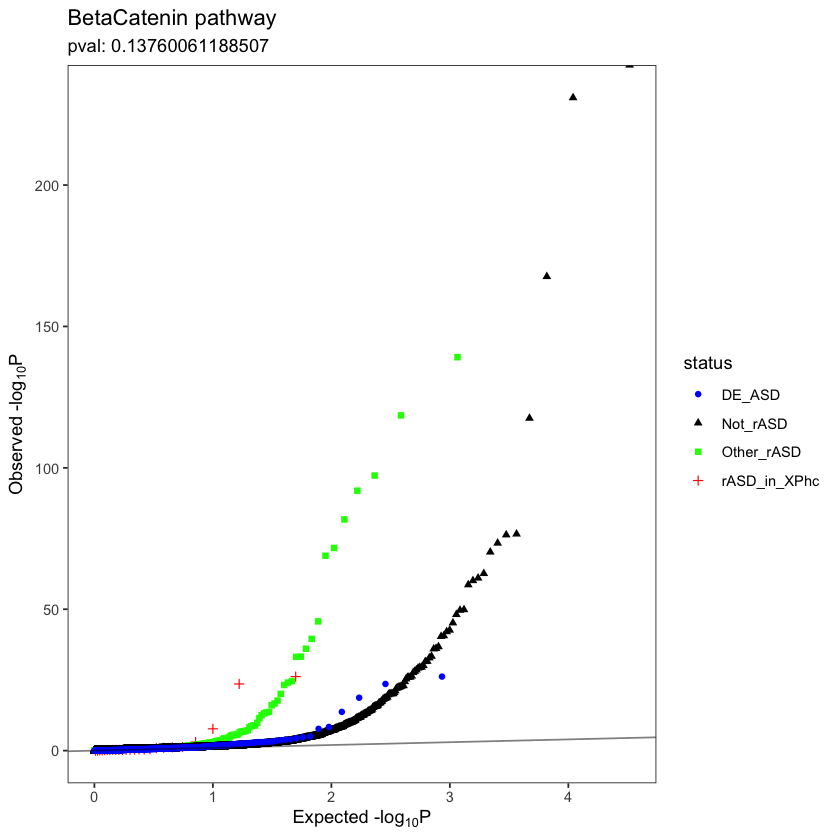

In [228]:

BetaCatenindata=gene2pathway[gene2pathway$target=="BetaCatenin",]
BetaCatenindata$isXP="Not_rASD"
BetaCatenindata$isXP[BetaCatenindata$entrezgene %in% sfariAtts$Entrez_Gene_ID]="Other_rASD"
BetaCatenindata$isXP[BetaCatenindata$entrezgene %in% intersect(test_score_table[1:500,]$gene,sfariAtts$Entrez_Gene_ID)]="rASD_in_XPhc"
tmp=BetaCatenindata[BetaCatenindata$entrezgene %in% test_score_table[1:500,]$gene,]
tmp$isXP="DE-ASD"
BetaCatenindata=rbind(BetaCatenindata,tmp)

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="DE-ASD"])
tmp$status="DE_ASD"
qqRes=rbind(qqRes,tmp)

 ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,shape=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black",DE_ASD="blue"))+
 ggtitle("BetaCatenin pathway",paste("pval:",wilcox.test(BetaCatenindata$Pv[BetaCatenindata$isXP=="Not_rASD"],BetaCatenindata$Pv[BetaCatenindata$isXP=="rASD_in_XPhc"])$p.value))

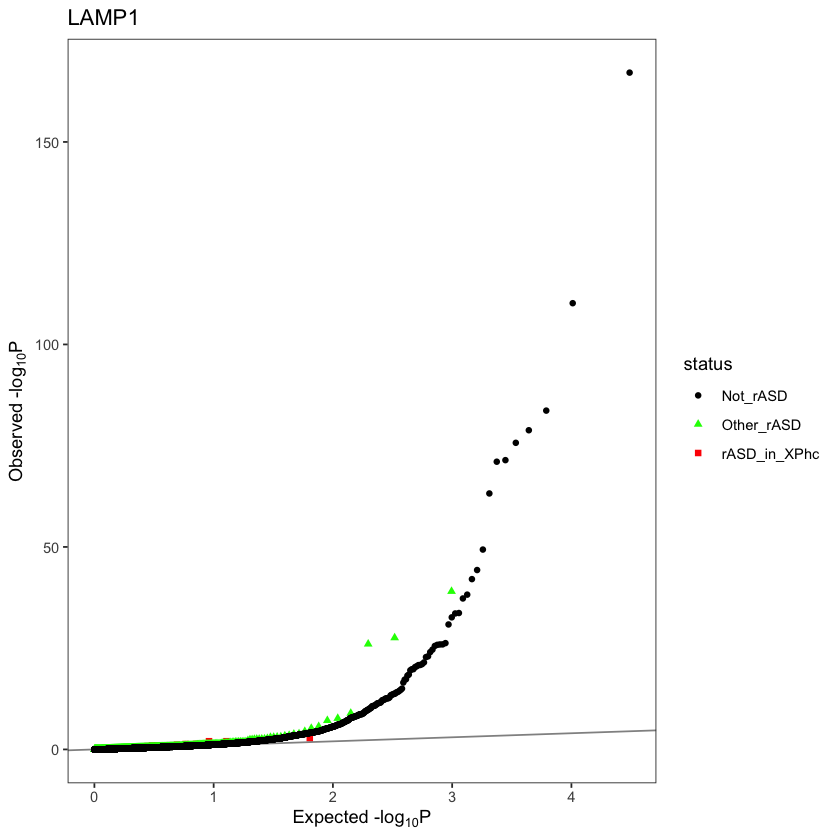

In [231]:

IRF1data=gene2pathway$entrezgene[gene2pathway$target=="IRF1"&gene2pathway$FCPv<0.1]
XBP1data=gene2pathway$entrezgene[gene2pathway$target=="XBP1"&gene2pathway$FCPv<0.1]
GNB1data=gene2pathway$entrezgene[gene2pathway$target=="GNB1"&gene2pathway$FCPv<0.1]
H2Adata=gene2pathway$entrezgene[gene2pathway$target=="Histone H2A(K119) crotonylation"&gene2pathway$FCPv<0.1]
H3Kdata=gene2pathway$entrezgene[gene2pathway$target=="Histone H3(K27) trimethylation"&gene2pathway$FCPv<0.1]
H3Kdata=gene2pathway$entrezgene[gene2pathway$target=="LAMP1"&gene2pathway$FCPv<0.1]
bkg=data.frame(table(as.factor(c(IRF1data,XBP1data,GNB1data,H2Adata,H3Kdata))))

#assessing the enrichment of rASD genes for signaling pathway other than PI3k/AKT, RAS/ERK, and WNT/Bcatenin
LAMP1data=gene2pathway[gene2pathway$target=="LAMP1",]
xAKT=AKTdata[AKTdata$FCPv<0.1,]
xERK=ERKdata[ERKdata$FCPv<0.1,]
xBcatenin=BetaCatenindata[BetaCatenindata$FCPv<0.1,]
tst=data.frame(table(as.factor(c(xAKT$entrezgene,xERK$entrezgene,xBcatenin$entrezgene))))
##To remove teh confounding effects, we remove the genes that regulate at least two of three signaling pathways of RAS/ERK, PI3K/AKT, and WNT/B-catenin
LAMP1data=LAMP1data[!(LAMP1data$entrezgene %in% tst$Var1[tst$Freq>1]),]
LAMP1data$isXP="Not_rASD"
LAMP1data$isXP[LAMP1data$entrezgene %in% sfariAtts$Entrez_Gene_ID]="Other_rASD"
LAMP1data$isXP[LAMP1data$entrezgene %in% intersect(complete_score_table_1000$gene,sfariAtts$Entrez_Gene_ID)]="rASD_in_XPhc"
tmp=.myQQplotFn(LAMP1data$Pv[LAMP1data$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp

tmp=.myQQplotFn(LAMP1data$Pv[LAMP1data$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(LAMP1data$Pv[LAMP1data$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

  ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,shape=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black"))+
  ggtitle("LAMP1")

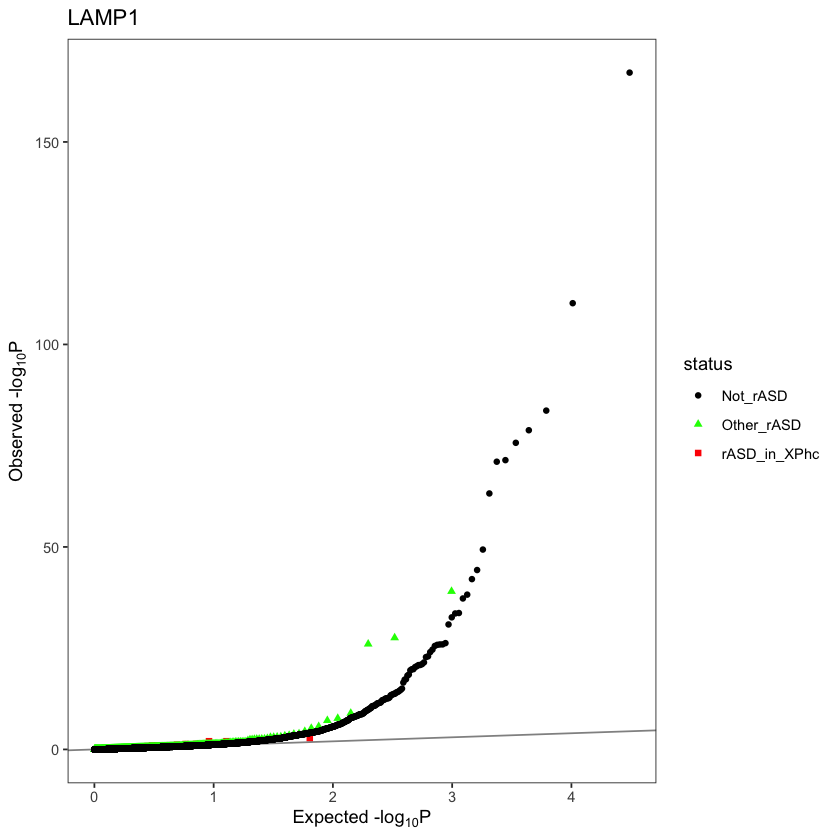

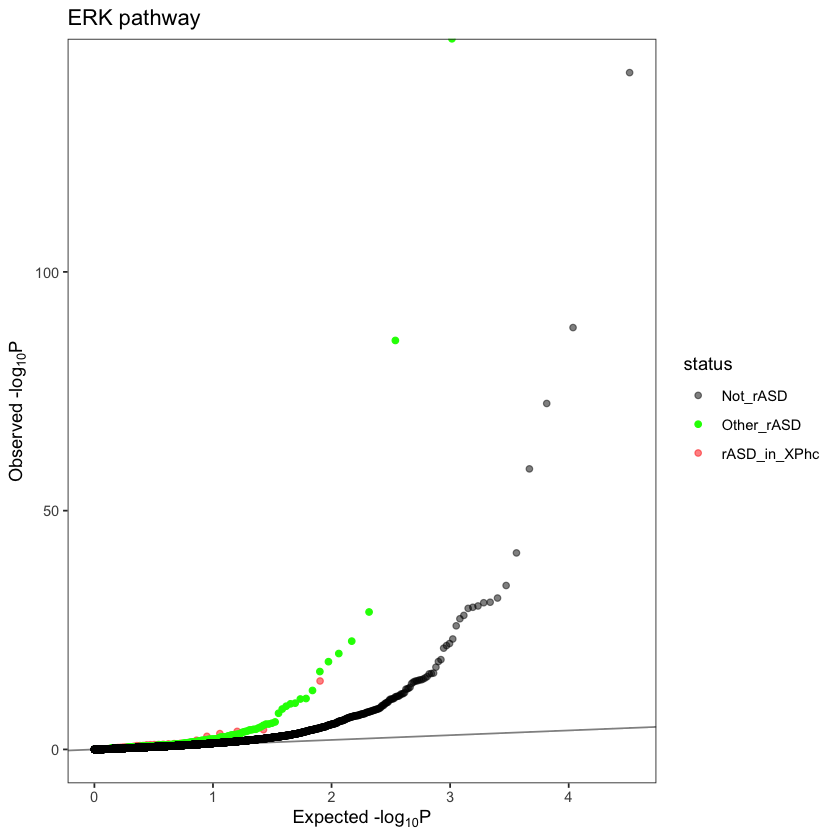

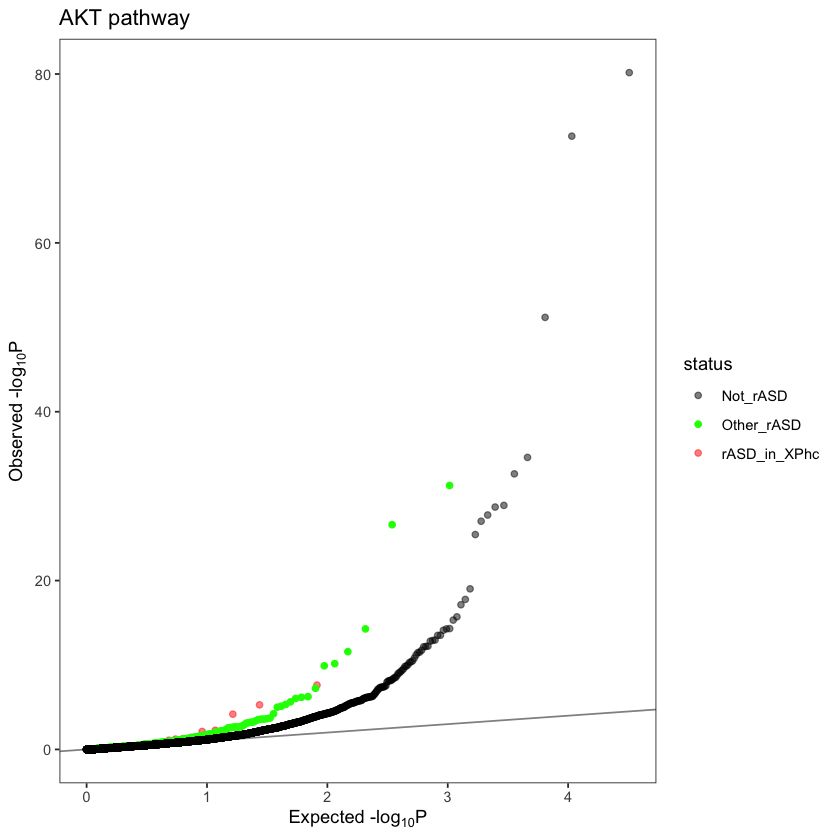

Loading required package: VennDiagram

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:topGO’:

    depth


Loading required package: futile.logger



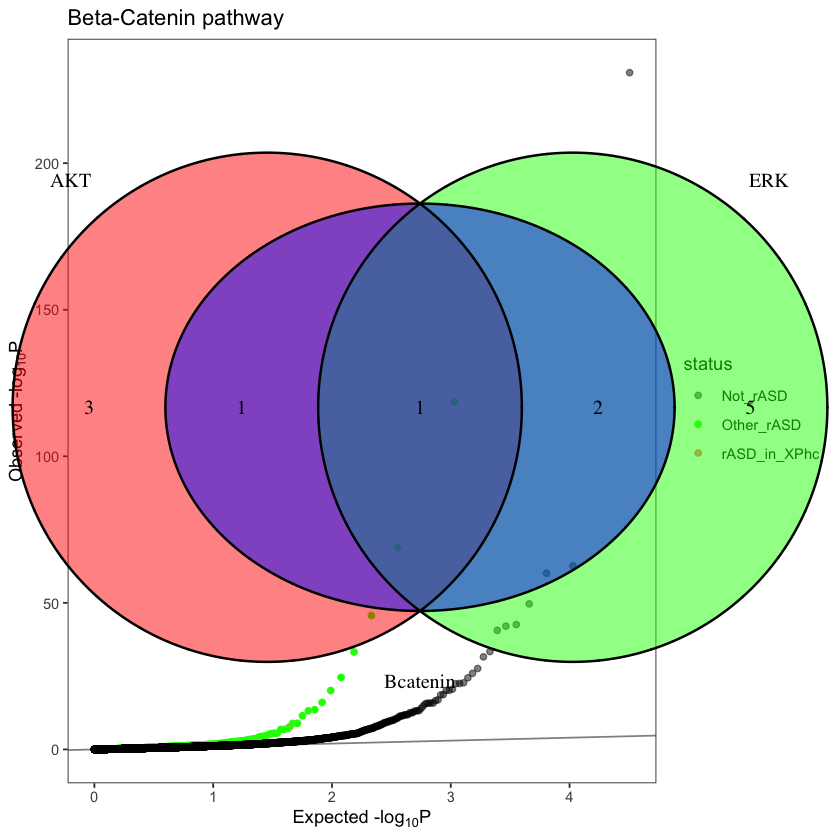

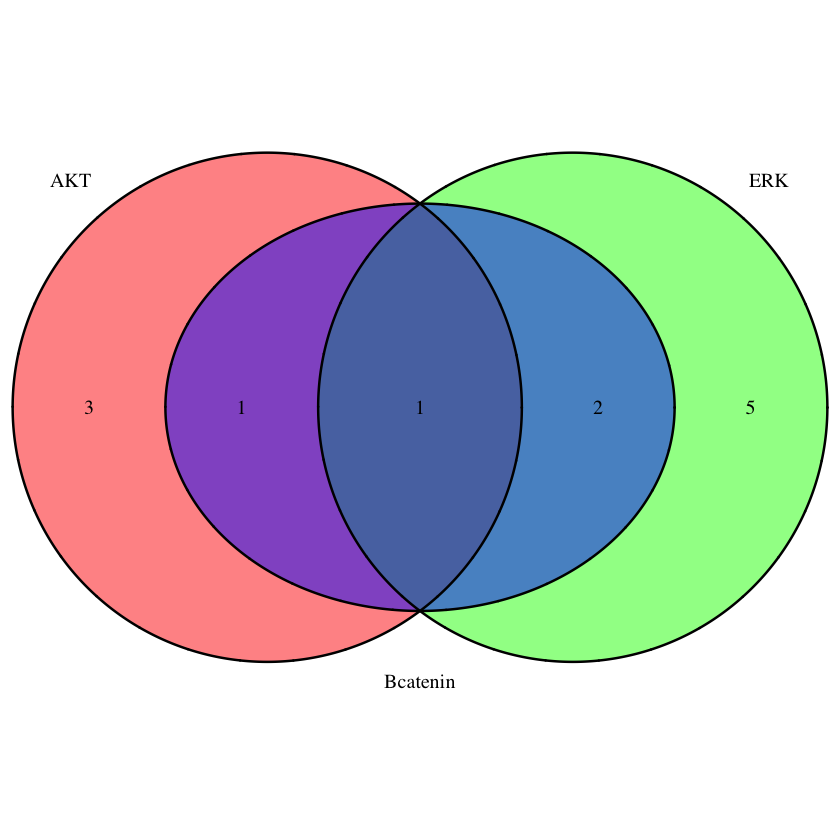

In [232]:
ERKdata2=ERKdata 
AKTdata2=AKTdata
BetaCatenindata2=BetaCatenindata


#Confirming genes that regulate multiple signaling pathways are not driving the observed enrichment of rASD genes for regulators of PI3K/AKT, RAS/ERK, and WNT/Bcatenin
#Constructing the background genelist

IRF1data=gene2pathway$entrezgene[gene2pathway$target=="IRF1"&gene2pathway$FCPv<0.1]
XBP1data=gene2pathway$entrezgene[gene2pathway$target=="XBP1"&gene2pathway$FCPv<0.1]
GNB1data=gene2pathway$entrezgene[gene2pathway$target=="GNB1"&gene2pathway$FCPv<0.1]
H2Adata=gene2pathway$entrezgene[gene2pathway$target=="Histone H2A(K119) crotonylation"&gene2pathway$FCPv<0.1]
H3Kdata=gene2pathway$entrezgene[gene2pathway$target=="Histone H3(K27) trimethylation"&gene2pathway$FCPv<0.1]
H3Kdata=gene2pathway$entrezgene[gene2pathway$target=="LAMP1"&gene2pathway$FCPv<0.1]
bkg=data.frame(table(as.factor(c(IRF1data,XBP1data,GNB1data,H2Adata,H3Kdata))))

#assessing the enrichment of rASD genes for signaling pathway other than PI3k/AKT, RAS/ERK, and WNT/Bcatenin
LAMP1data=gene2pathway[gene2pathway$target=="LAMP1",]
xAKT=AKTdata[AKTdata$FCPv<0.1,]
xERK=ERKdata[ERKdata$FCPv<0.1,]
xBcatenin=BetaCatenindata[BetaCatenindata$FCPv<0.1,]
tst=data.frame(table(as.factor(c(xAKT$entrezgene,xERK$entrezgene,xBcatenin$entrezgene))))
##To remove teh confounding effects, we remove the genes that regulate at least two of three signaling pathways of RAS/ERK, PI3K/AKT, and WNT/B-catenin
LAMP1data=LAMP1data[!(LAMP1data$entrezgene %in% tst$Var1[tst$Freq>1]),]
LAMP1data$isXP="Not_rASD"
LAMP1data$isXP[LAMP1data$entrezgene %in% sfariAtts$Entrez_Gene_ID]="Other_rASD"
LAMP1data$isXP[LAMP1data$entrezgene %in% intersect(complete_score_table_1000$gene,sfariAtts$Entrez_Gene_ID)]="rASD_in_XPhc"
tmp=.myQQplotFn(LAMP1data$Pv[LAMP1data$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp

tmp=.myQQplotFn(LAMP1data$Pv[LAMP1data$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(LAMP1data$Pv[LAMP1data$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

  ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,shape=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black"))+
  ggtitle("LAMP1")
 
  
#ERK pathway
ERKdata=ERKdata2
##Removing genes that regulate at least two of background (negative control) signaling pathways
ERKdata=ERKdata[!(ERKdata$entrezgene %in% bkg$Var1[bkg$Freq>1]),]
tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp


tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(ERKdata$Pv[ERKdata$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

  ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,alpha=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black"))+
  scale_alpha_manual(values=c(rASD_in_XPhc=0.5,Other_rASD=1,Not_rASD=0.5))+ggtitle("ERK pathway")
  

#AKT pathway
AKTdata=AKTdata2
##Removing genes that regulate at least two of background (negative control) signaling pathways
AKTdata=AKTdata[!(AKTdata$entrezgene %in% bkg$Var1[bkg$Freq>1]),]
tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp

tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(AKTdata$Pv[AKTdata$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

  ggplot(qqRes) +
    geom_point(aes(expected, observed,color=status,alpha=status)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)+theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black"))+
  scale_alpha_manual(values=c(rASD_in_XPhc=0.5,Other_rASD=1,Not_rASD=0.5))+ggtitle("AKT pathway")


#Bcatenin pathway
BetaCatenindata=BetaCatenindata2
##Removing genes that regulate at least two of background (negative control) signaling pathways
BetaCatenindata=BetaCatenindata[!(BetaCatenindata$entrezgene %in% bkg$Var1[bkg$Freq>1]),]

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="rASD_in_XPhc"])
tmp$status="rASD_in_XPhc"
qqRes=tmp

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="Other_rASD"])
tmp$status="Other_rASD"
qqRes=rbind(qqRes,tmp)

tmp=.myQQplotFn(BetaCatenindata$Pv[BetaCatenindata$isXP=="Not_rASD"])
tmp$status="Not_rASD"
qqRes=rbind(qqRes,tmp)

ggplot(qqRes) +
  geom_point(aes(expected, observed,color=status,alpha=status)) +
  geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
  xlab(log10Pe) +
  ylab(log10Po)+theme_bw()+theme(panel.grid = element_blank())+scale_color_manual(values=c(rASD_in_XPhc="red",Other_rASD="green",Not_rASD="black"))+
  scale_alpha_manual(values=c(rASD_in_XPhc=0.5,Other_rASD=1,Not_rASD=0.5))+ggtitle("Beta-Catenin pathway")


#Venn Diagram for the overlap between the regulators of the three signaling pathways of RAS/ERK, PI3K/AKT, and WNT/B-catenin
xERK=ERKdata2[ERKdata2$isXP=="rASD_in_XPhc",]
xBcatenin=BetaCatenindata2[BetaCatenindata2$isXP=="rASD_in_XPhc",]
xAKT=AKTdata2[AKTdata2$isXP=="rASD_in_XPhc",]
xERK=xERK[xERK$FCPv<0.1,]
xAKT=xAKT[xAKT$FCPv<0.1,]
xBcatenin=xBcatenin[xBcatenin$FCPv<0.1,]

require(VennDiagram)
venn.plot=draw.triple.venn(length(xAKT$entrezgene), nrow(xERK), nrow(xBcatenin), length(intersect(xAKT$entrezgene,xERK$entrezgene)), length(intersect(xERK$entrezgene,xBcatenin$entrezgene)), length(intersect(xAKT$entrezgene,xBcatenin$entrezgene)), length(intersect(xAKT$entrezgene,intersect(xERK$entrezgene,xBcatenin$entrezgene))),category = c("AKT","ERK","Bcatenin"),fill=c("red","green","blue"))
grid.newpage();
grid.draw(venn.plot);


# GSEA

In [282]:
xOriginal=.readGeneSetData("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/rawData/GeneSets/msigdb.v5.1.entrez.gmt",allProteinCodingGenes,10,10000)

#reading in the GSEA reasults on ASD and TD samples
#code for GSEA analysis: .myGSEAwrapperFn(expAdj,pData(expAdj)$diagnosis_binary)
#The input file below is the list of all significant genesests (GSEA FDR < 0.1; default setting), excluding the genesets derived from specific datasets (176 genesets)
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/CompiledData/totalSigGSTerms.rda")

x=xOriginal[row.names(xOriginal) %in% slGSs,]


In [ ]:
# gNet=.myNetGeneExtractorFn(netMProbandCombined)
# gNetFuncGeneMania=.myNetGeneExtractorFn(netFuncGeneManiaMProband)
# gNetFull=.myNetGeneExtractorFn(netFullMProbandCombined)

# all_score_table_500$gene
# complete_score_table_500$gene
# test_score_table[1:500,]$gene
# random_table$gene,gsData

In [284]:

gNet=all_score_table_500$gene
gNetFuncGeneMania=complete_score_table_500$gene
gNetFull=test_score_table[1:500,]$gene

gsPvales=data.frame(gs="a",
                    empHC=0,
                    empFuncGeneMania=0,
                    empFull=0,
                    theoHC=0,
                    theoFuncGeneMania=0,
                    theoFull=0,
                    stringsAsFactors = F)
for(i in 1:nrow(x)){
  gGStmp=colnames(x)[x[i,]=="a"]
  commonHC=length(intersect(gNet,gGStmp))
  commonFuncGeneMania=length(intersect(gNetFuncGeneMania,gGStmp))
  commonFull=length(intersect(gNetFull,gGStmp))
  
  theoHC=sum(dhyper(commonHC:min(length(gGStmp),length(gNet)),max(length(gGStmp),length(gNet)),length(allProteinCodingGenes)-max(length(gGStmp),length(gNet)),min(length(gGStmp),length(gNet))))
  
  theoFuncGeneMania=sum(dhyper(commonHC:min(length(gGStmp),length(gNetFuncGeneMania)),max(length(gGStmp),length(gNetFuncGeneMania)),length(allProteinCodingGenes)-max(length(gGStmp),length(gNetFuncGeneMania)),min(length(gGStmp),length(gNetFuncGeneMania))))
  
  theoFull=sum(dhyper(commonHC:min(length(gGStmp),length(gNetFull)),max(length(gGStmp),length(gNetFull)),length(allProteinCodingGenes)-max(length(gGStmp),length(gNetFull)),min(length(gGStmp),length(gNetFull))))
 
  tmpHC=0
  tmpFuncGeneMania=0
  tmpFull=0
  if(commonHC>0){
  for(irand in 1:100){
    tstHC=sample(allProteinCodingGenes,length(gNet),replace = F)
    tmpHC=c(tmpHC,length(intersect(tstHC,gGStmp)))
  }
    
    if(sum(tmpHC>=commonHC)<5){
      for(irand in 1:9900){
    tstHC=sample(allProteinCodingGenes,length(gNet),replace = F)
    tmpHC=c(tmpHC,length(intersect(tstHC,gGStmp)))
      }
     if(sum(tmpHC>=commonHC)<2){
      for(irand in 1:90000){
    tstHC=sample(allProteinCodingGenes,length(gNet),replace = F)
    tmpHC=c(tmpHC,length(intersect(tstHC,gGStmp)))
      } 
    } 
    }
    tmpHC=tmpHC[-1]
  } else {
    tmpHC=rep(1,10000)
  }
  
  if(commonFuncGeneMania>0){
  for(irand in 1:100){
    tstFuncGeneMania=sample(allProteinCodingGenes,length(gNetFuncGeneMania),replace=F)
    tmpFuncGeneMania=c(tmpFuncGeneMania,length(intersect(tstFuncGeneMania,gGStmp)))
  }
    if(sum(tmpFuncGeneMania>=commonFuncGeneMania)<5){
      for(irand in 1:9900){
        tstFuncGeneMania=sample(allProteinCodingGenes,length(gNetFuncGeneMania),replace=F)
        tmpFuncGeneMania=c(tmpFuncGeneMania,length(intersect(tstFuncGeneMania,gGStmp)))
      }
      if(sum(tmpFuncGeneMania>=commonFuncGeneMania)<2){
      for(irand in 1:90000){
        tstFuncGeneMania=sample(allProteinCodingGenes,length(gNetFuncGeneMania),replace=F)
        tmpFuncGeneMania=c(tmpFuncGeneMania,length(intersect(tstFuncGeneMania,gGStmp)))
      }
    }
    }
    tmpFuncGeneMania=tmpFuncGeneMania[-1]
  } else {
    tmpFuncGeneMania=rep(1,10000)
  }
  
  
  if(commonFull>0){
  for(irand in 1:100){
    tstFull=sample(allProteinCodingGenes,length(gNetFull),replace=F)
    tmpFull=c(tmpFull,length(intersect(tstFull,gGStmp)))
  }
    if(sum(tmpFull>=commonFull)<5){
      for(irand in 1:9900){
        tstFull=sample(allProteinCodingGenes,length(gNetFull),replace=F)
        tmpFull=c(tmpFull,length(intersect(tstFull,gGStmp)))
      }
      if(sum(tmpFull>=commonFull)<2){
      for(irand in 1:90000){
        tstFull=sample(allProteinCodingGenes,length(gNetFull),replace=F)
        tmpFull=c(tmpFull,length(intersect(tstFull,gGStmp)))
      }
    }
    }
    tmpFull=tmpFull[-1]
  } else {
    tmpFull=rep(1,10000)
  }
    
  gsPvales=rbind(gsPvales,
                 data.frame(gs=row.names(x)[i],
                            empHC=sum(tmpHC>=commonHC)/length(tmpHC),
                            empFuncGeneMania=sum(tmpFuncGeneMania>=commonFuncGeneMania)/length(tmpFuncGeneMania),
                            empFull=sum(tmpFull>=commonFull)/length(tmpFull),
                            theoHC=theoHC,
                            theoFuncGeneMania=theoFuncGeneMania,
                            theoFull=theoFull,
                            stringsAsFactors = F))
}
gsPvales=gsPvales[-1,]

x=gsPvales$empHC
if(sum(x==0)>0){
 x[x==0]=gsPvales$theoHC[x==0] 
}
gsPvales$FDRhc=p.adjust(x,method="fdr")

x=gsPvales$empFuncGeneMania
if(sum(x==0)>0){
  x[x==0]=gsPvales$theoFuncGeneMania[x==0]
}
gsPvales$FDRfuncGeneMania=p.adjust(x,method="fdr")


x=gsPvales$empFull
if(sum(x==0)>0){
  x[x==0]=gsPvales$theoFull[x==0]
}
gsPvales$FDRfull=p.adjust(x,method="fdr")


In [302]:
# save(gsPvales,file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/goGSEA.rda")
# rm(xOriginal,indx,slGSs,tstNames,x,x2,gsPvales,pvalFull,pvalFuncGeneMania,pvalFuncBrain,pvalHC,tstFull,tstFuncGeneMania,tstHC,tmpFull,tmpFuncGeneMania,tmpFuncBrain,tmpHC,slGenesFull,slGenesFuncGeneMania,slGenesHC,i,irand,gs.db,wGenes,genesInNetFull,genesInNetFuncGeneMania,genesInNetHC,gGStmp,gNet,gNetFull,gNetFuncGeneMania,commonHC,commonFull,commonFuncGeneMania,theoFull,theoFuncGeneMania,theoHC)

In [304]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/goGSEA.rda")
head(gsPvales)

,gs,empHC,empFuncGeneMania,empFull,theoHC,theoFuncGeneMania,theoFull,FDRhc,FDRfuncGeneMania,FDRfull
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,ENDOSOME,0.0800,0.7200,0.5700,0.065535908,0.065535908,0.065535908,0.3028571,0.8977551,0.8885294
3,NEURITE_DEVELOPMENT,0.0178,0.0700,0.0745,0.015265136,0.015265136,0.015265136,0.1347714,0.4164286,0.3948500
4,CELLULAR_MORPHOGENESIS_DURING_DIFFERENTIATION,0.0077,0.0456,0.0500,0.007644295,0.007644295,0.007644295,0.1020250,0.4164286,0.3312500
5,GENERATION_OF_NEURONS,0.1200,0.2300,0.2100,0.065991884,0.065991884,0.065991884,0.3180000,0.6415789,0.5830000
6,REGULATION_OF_CELLULAR_COMPONENT_ORGANIZATION_AND_BIOGENESIS,0.2300,0.1100,0.1300,0.226984861,0.226984861,0.226984861,0.5079167,0.4164286,0.5300000
7,JNK_CASCADE,0.4600,0.8000,0.7500,0.414744893,0.414744893,0.414744893,0.6732432,0.8977551,0.9154545


In [ ]:
all_score_table_500$gene
complete_score_table_500$gene
test_score_table[1:500,]$gene
random_table$gene,gsData

In [249]:
.myGOdetailedFn=function(items,inputGene,goTerms,allAnotation,allAnotatedGenes){
  #this function is a sub-function of .myGOenrichmentFn and is not meant to be run separately
  dfRes=data.frame(term="a",description="a",annotated=1,significant=1,pvalFisher=1,isEnriched=0,stringsAsFactors = F)
  for(i in items){
  tmpDesc=unique(goTerms$TERM[goTerms$GOID==i])
  #GOgenes=intersect(unique(select(org.Hs.eg.db, i, "ENTREZID","GOALL")$ENTREZID),allProteinCodingGenes)
  GOgenes <- unique(allAnotation$ENTREZID[which(allAnotation$GOALL==i)])
  if(length(GOgenes)>0){
    cGOgenes=setdiff(allAnotatedGenes,GOgenes)
    common=intersect(GOgenes,inputGene)
    
    pvalHC=fisher.test(rbind(c(length(common),length(GOgenes)-length(common)),c(length(intersect(inputGene,cGOgenes)),length(setdiff(cGOgenes,inputGene)))))$p.value
    
    enrichedHC=fisher.test(rbind(c(length(common),length(GOgenes)-length(common)),c(length(intersect(inputGene,cGOgenes)),length(setdiff(cGOgenes,inputGene)))),alternative = "g")$p.value
    
    dfRes=rbind(dfRes,data.frame(term=i,description=tmpDesc,annotated=length(GOgenes),significant=length(common),pvalFisher=pvalHC,isEnriched=enrichedHC,stringsAsFactors = F))
  }
  }
  dfRes=dfRes[-1,]
  
  return(dfRes)
}
.myGOenrichmentFn=function(inputGene,inputBkg,inputOntology=c("BP","MF","CC"),inputMinNodeSize=9,inputMaxNodeSize=1000,GOall=T){
  #input ontology can be "BP", "CC","MF", and a combination of thereof; e.g., c("MF","BP","CC")
  #if GOALL is off, a limited number of annotated genes will be used for the enrichment test
  #inputGene and inputBkg are supposed to be in gene entrez ids
  
require(org.Hs.eg.db)
require("GO.db")
  
validGoIDs=(keys(org.Hs.eg.db, keytype="GO"))
if(GOall){
allAnotation= AnnotationDbi::select(org.Hs.eg.db,columns = c("ENTREZID","GOALL","ONTOLOGYALL"),keys=as.character(inputBkg),keytypes="ENTREZID")
} else {
  allAnotation= AnnotationDbi::select(org.Hs.eg.db,columns = c("ENTREZID","GO"),keys=as.character(inputBkg),keytypes="ENTREZID")
}

goTerms=AnnotationDbi::select(GO.db, validGoIDs, c("TERM","ONTOLOGY"), "GOID")
goTerms=goTerms[goTerms$ONTOLOGY %in% inputOntology,]

#GOlist=GOlevels[grepl("cell_cycle",GOlevels$description),]
#GOmapper=GOmapper[GOmapper$GO %in% GOlist,]
allAnotatedGenes=allAnotation[allAnotation$GO %in% goTerms$GOID,]
allAnotatedGenes=unique(allAnotatedGenes$ENTREZID)

tst=split(goTerms$GOID,cut(1:length(goTerms$GOID),10))
res=mclapply(tst,.myGOdetailedFn,inputGene,goTerms,allAnotation,allAnotatedGenes,mc.cores = 5)
dfRes <- do.call("rbind", res)

dfRes$isEnriched[dfRes$isEnriched>0.5]=(-1)
dfRes$isEnriched[dfRes$isEnriched>=0]=1
dfRes=dfRes[dfRes$annotated>inputMinNodeSize&dfRes$annotated<inputMaxNodeSize,]

dfRes$fdr=p.adjust(dfRes$pvalFisher,method="fdr")
row.names(dfRes)=dfRes$term
return(dfRes)
}

.myGOtreeFn=function(Goterms,bkgGenes){
  #This function constructs the Gene Ontology (GO) tree of input GO terms based on the information in the Amigo database
  #Goterms: input Go terms
  #bkgGenes: vector of background genes used for the enrichment analysis
  
  require(RamiGO)
  require(org.Hs.eg.db)
  require(GO.db)
  
  validGoIDs=(keys(org.Hs.eg.db, keytype="GO"))
  allAnotation= select(org.Hs.eg.db,columns = c("ENTREZID","GOALL","ONTOLOGYALL"),keys=as.character(bkgGenes),keytypes="ENTREZID")
  counts=as.data.frame(table(allAnotation$GOALL))
  rm(allAnotation)
  
  goDesc=select(GO.db, validGoIDs, c("TERM","ONTOLOGY"), "GOID")
  
  dotRes <- getAmigoTree(goIDs=Goterms, color="red", filename="example", picType="dot", saveResult=F)
inputData <- strsplit(dotRes, ";")[[1]]

metaData <- inputData[!grepl("->",inputData)]
metaData <- metaData[grepl("node",metaData)]
metaData <- metaData[grepl("GO:",metaData)]
    nodeData <- inputData[grepl("->",inputData)]

    metaData=gsub("\n","",metaData)
    metaData=gsub("\t","",metaData)
    nodeData=gsub("\n","",nodeData)
    nodeData=gsub("\t","",nodeData)
    
indx=regexpr(" ",metaData)
metaDataId=substr(metaData,1,indx-1)
metaData=substr(metaData,indx+1,nchar(metaData))

indx=regexpr("GO:",metaData)
metaData=substr(metaData,indx,nchar(metaData))
indx=regexpr("<br",metaData)
metaData=substr(metaData,1,indx-1)

dfMapper=data.frame(nodeId=metaDataId,nodeName=metaData,stringsAsFactors = F)

Annotation=merge(dfMapper,goDesc,by.x="nodeName",by.y="GOID",all.x=T)
Annotation=merge(Annotation,counts,by.x="nodeName",by.y='Var1',all.x=T)
if(sum(colnames(Annotation)=="nodeId")>0){
  Annotation=Annotation[,-which(colnames(Annotation)=="nodeId")]
}

indx=regexpr(" ",nodeData)
Fnode=substr(nodeData,1,indx-1)
nodeData=substr(nodeData,indx+1,nchar(nodeData))

indx=regexpr(" ",nodeData)
nodeData=substr(nodeData,indx+1,nchar(nodeData))
indx=regexpr(" ",nodeData)
Snode=substr(nodeData,1,indx-1)

dfNet=data.frame(Fnode=Fnode,Snode=Snode,stringsAsFactors = F)

dfNet=merge(dfNet,dfMapper,by.x="Fnode",by.y="nodeId",all.x=T)
dfNet=merge(dfNet,dfMapper,by.x="Snode",by.y="nodeId",all.x=T)
dfNet=dfNet[,c(3,4)]
colnames(dfNet)=c("Fnode","Snode")
return(list(net=dfNet,annotation=Annotation))
}

In [298]:
resXP=.myGOenrichmentFn(all_score_table_500$gene,allProteinCodingGenes,inputOntology = "BP",inputMaxNodeSize = 2000)

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [102]:
require(org.Hs.eg.db)
require("GO.db")
inputGene=all_score_table_500$gene
inputBkg=allProteinCodingGenes
inputOntology = "BP"
inputMaxNodeSize = 2000
validGoIDs=(keys(org.Hs.eg.db, keytype="GO"))
if(T){
allAnotation= AnnotationDbi::select(org.Hs.eg.db,columns = c("ENTREZID","GOALL","ONTOLOGYALL"),keys=as.character(inputBkg),keytypes="ENTREZID")
} else {
  allAnotation= AnnotationDbi::select(org.Hs.eg.db,columns = c("ENTREZID","GO"),keys=as.character(inputBkg),keytypes="ENTREZID")
}
goTerms=AnnotationDbi::select(GO.db, validGoIDs, c("TERM","ONTOLOGY"), "GOID")
goTerms=goTerms[goTerms$ONTOLOGY %in% inputOntology,]
allAnotatedGenes=allAnotation[allAnotation$GOALL %in% goTerms$GOID,]
allAnotatedGenes=unique(allAnotatedGenes$ENTREZID)
tst=split(goTerms$GOID,cut(1:length(goTerms$GOID),10))

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [103]:
res=mclapply(tst,.myGOdetailedFn,inputGene,goTerms,allAnotation,allAnotatedGenes,mc.cores = 5)
dfRes <- do.call("rbind", res)

dfRes$isEnriched[dfRes$isEnriched>0.5]=(-1)
dfRes$isEnriched[dfRes$isEnriched>=0]=1

In [248]:
dfRes[dfRes$pvalFisher<0.001 & dfRes$isEnriched==1,]

,term,description,annotated,significant,pvalFisher,isEnriched
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
"(-11.3,1.23e+03].126",GO:0006468,protein phosphorylation,1312,79,2.297381e-04,1
"(-11.3,1.23e+03].224",GO:0007165,signal transduction,3520,180,1.084331e-04,1
"(-11.3,1.23e+03].487",GO:0070885,negative regulation of calcineurin-NFAT signaling cascade,11,4,6.934536e-04,1
"(-11.3,1.23e+03].589",GO:0006796,phosphate-containing compound metabolic process,2289,121,9.705502e-04,1
"(-11.3,1.23e+03].695",GO:0051726,regulation of cell cycle,926,60,2.239656e-04,1
"(-11.3,1.23e+03].814",GO:0016310,phosphorylation,1640,94,2.931252e-04,1
"(1.23e+03,2.46e+03].59",GO:0007049,cell cycle,1424,83,4.937775e-04,1
"(1.23e+03,2.46e+03].148",GO:0045737,positive regulation of cyclin-dependent protein serine/threonine kinase activity,24,6,3.051948e-04,1
"(1.23e+03,2.46e+03].396",GO:0007154,cell communication,3782,191,1.155046e-04,1


In [ ]:

dfRes=dfRes[dfRes$annotated>inputMinNodeSize&dfRes$annotated<inputMaxNodeSize,]



 [1] gs                empHC             empFuncGeneMania  empFull          
 [5] theoHC            theoFuncGeneMania theoFull          FDRhc            
 [9] FDRfuncGeneMania  FDRfull          
<0 rows> (or 0-length row.names)


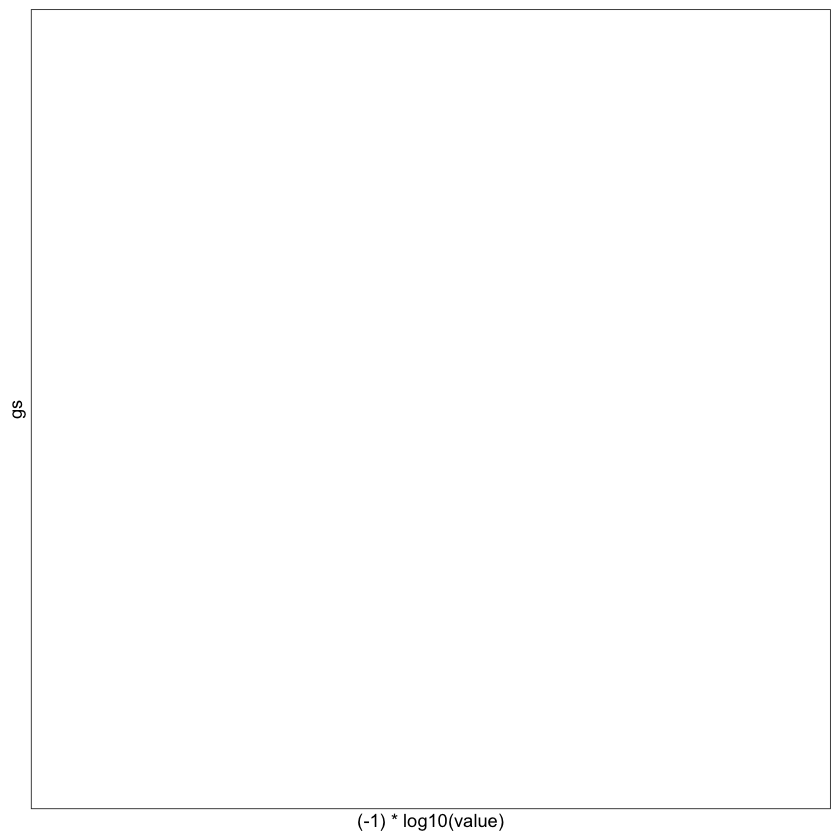

In [291]:
gsPvales=gsPvales[gsPvales$FDRhc<0.1&gsPvales$FDRfuncGeneMania<0.1&gsPvales$FDRfull<0.1,]

print(gsPvales)

x=melt(gsPvales[,c("FDRhc","FDRfuncGeneMania","FDRfull","gs")],id.vars = "gs")
tmp=x[x$variable=="FDRhc",]
tmp=tmp[order(tmp$value,decreasing = T),]
x$gs=factor(as.character(x$gs),levels=unique(tmp$gs))
ggplot(x,aes(gs,(-1)*log10(value),fill=variable))+geom_bar(stat = "identity",position = "dodge")+coord_flip()+theme_bw()+theme(axis.text = element_text(color="black"),panel.grid = element_blank())